# Groupe 02 :

<h1><font color='blue'> Sujet 1. Modèle de Rupture pour la loi de Weibull </font></h1>

<h2> Application aux données de CAC40 </h2>

In [1]:
%matplotlib inline
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from math import *
import sys
import warnings
import scipy.stats as st

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Fonction d'autocorrélation (l'équation 33 du cours avec $h=0$, page 19)

In [2]:
def TM_ACF(data,lag=1):
    data=np.array(data,dtype=np.float64)
    m=np.mean(data)
    T=len(data)
    V=sum([(data[t]-m)**2 for t in range(T)])
    #print("m=%s \t v=%s"%(m,V))
    C=sum([(data[t]-m)*(data[t+lag]-m) for t in range(T-lag)])
    R=C/(1.0*V)
    return R

## Visualiser les données de CAC40 sur les graphes
### Pour application, on sélectionne que les données à partir du 1er juin 2017

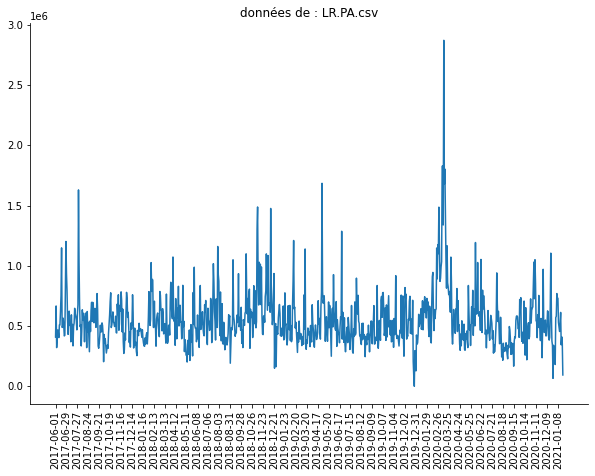

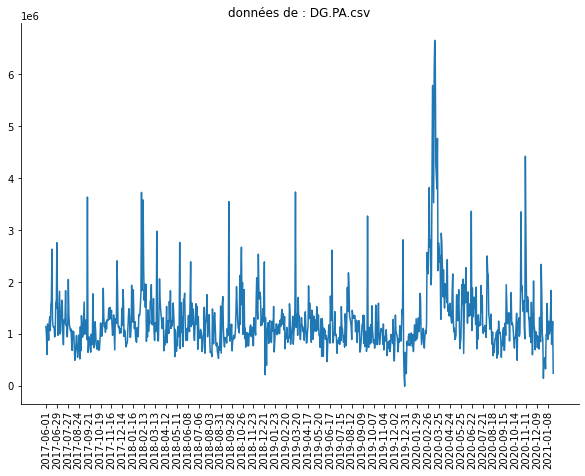

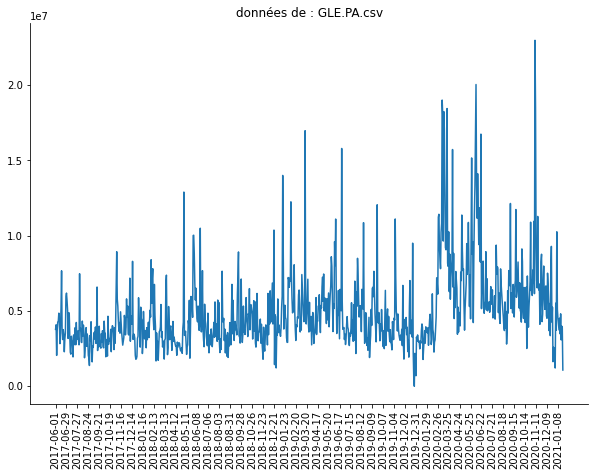

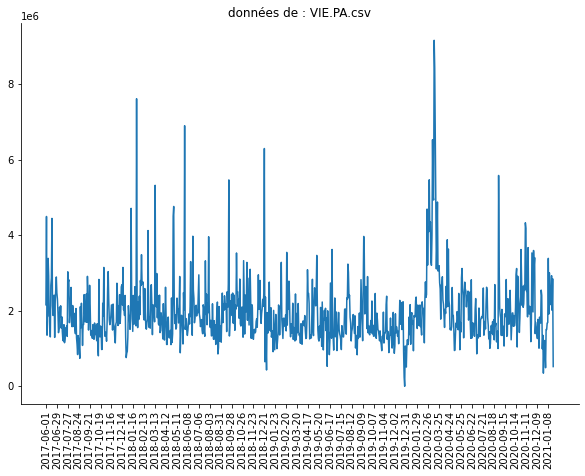

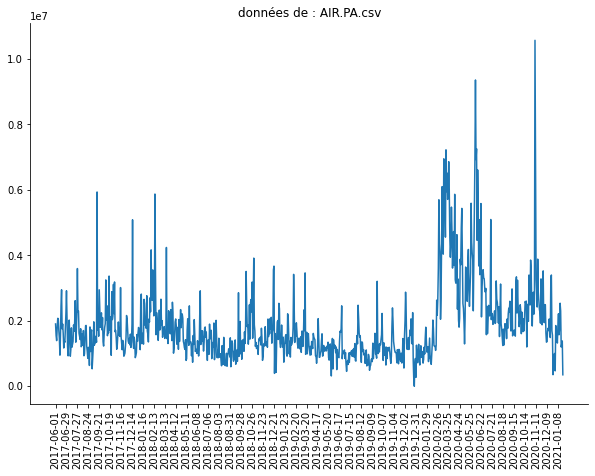

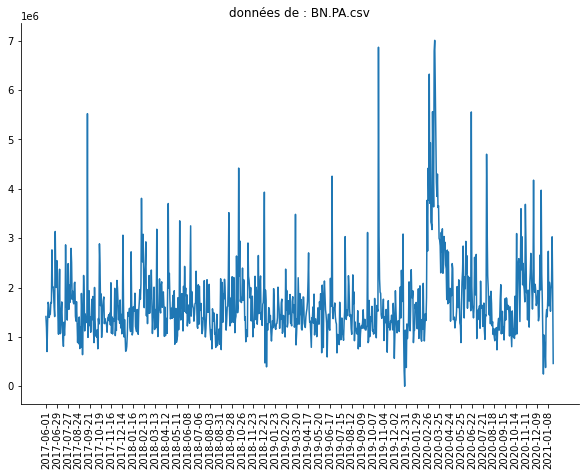

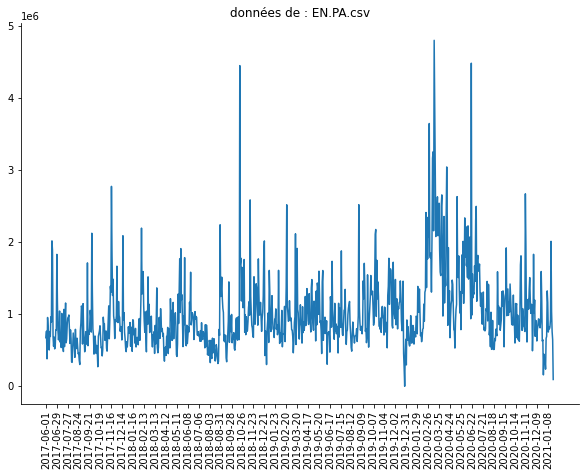

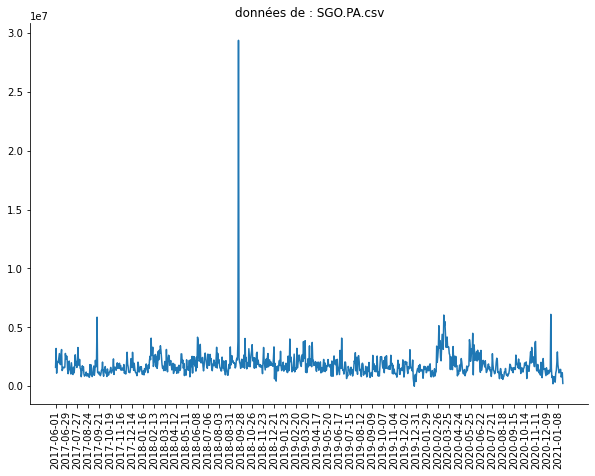

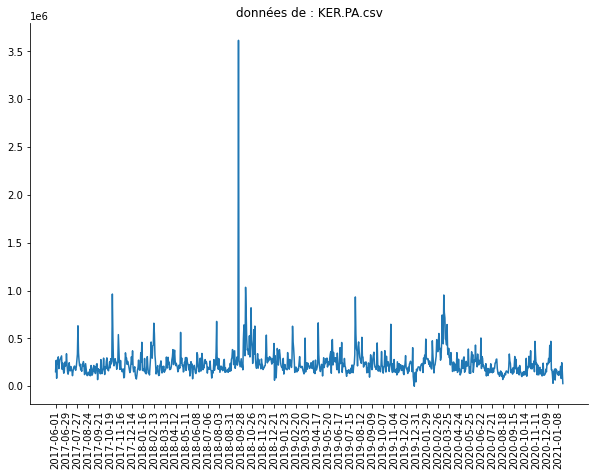

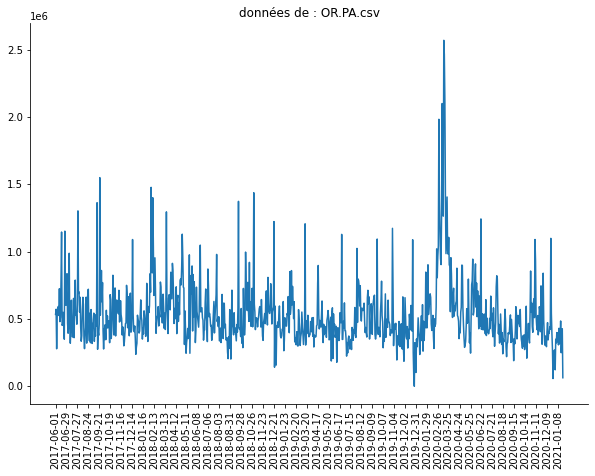

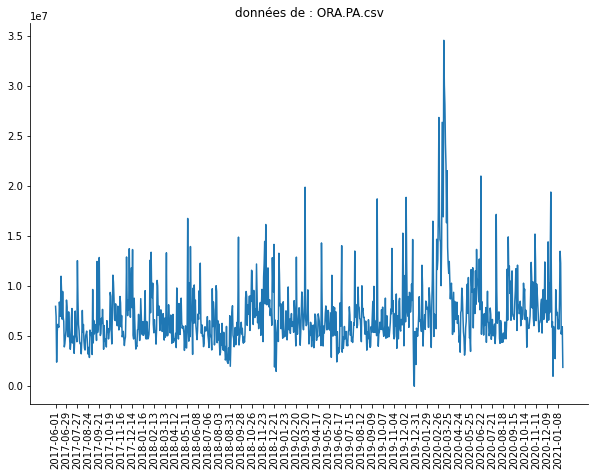

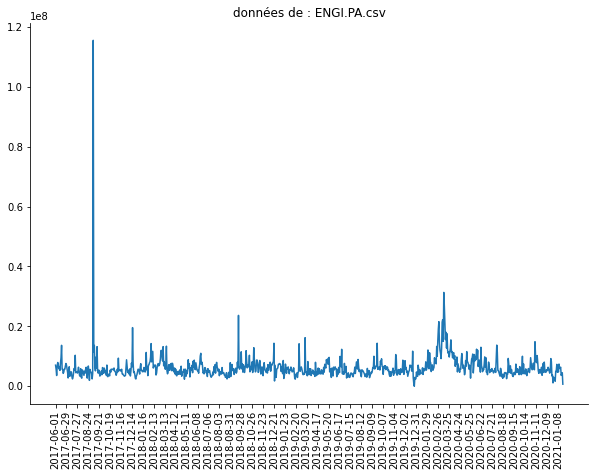

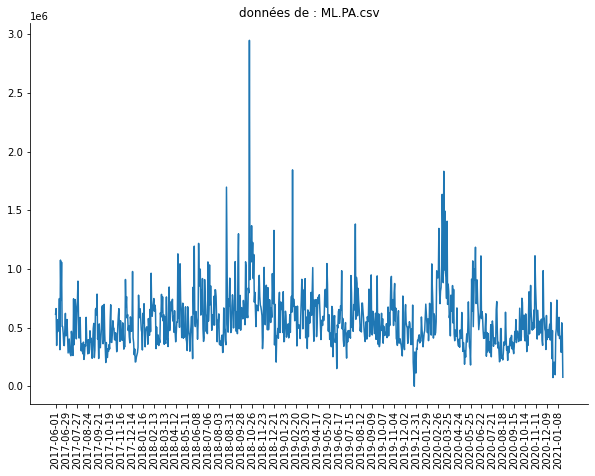

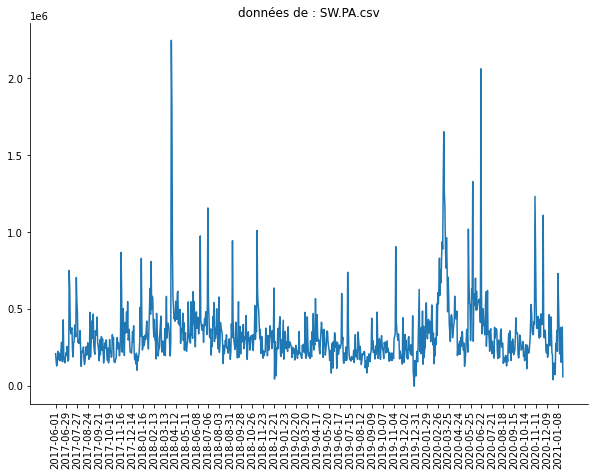

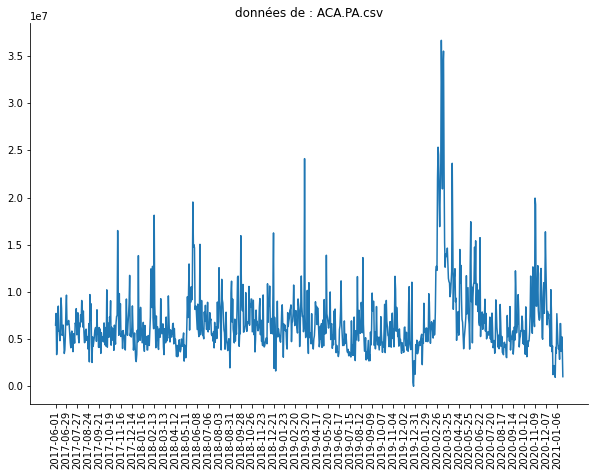

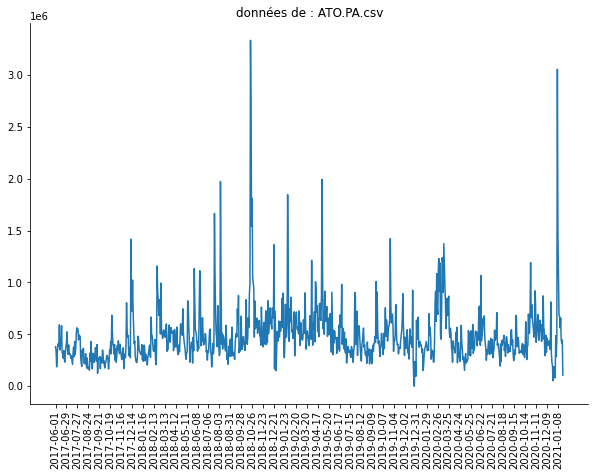

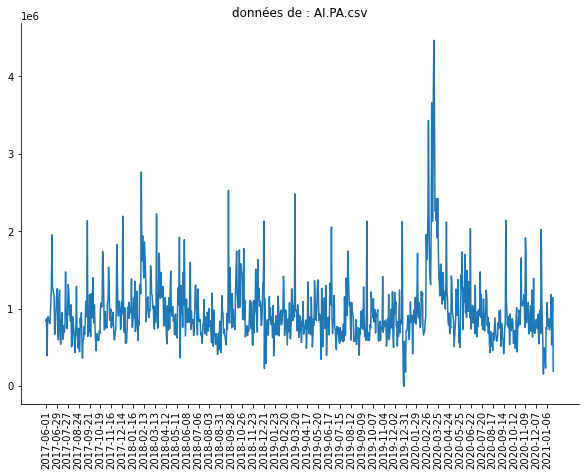

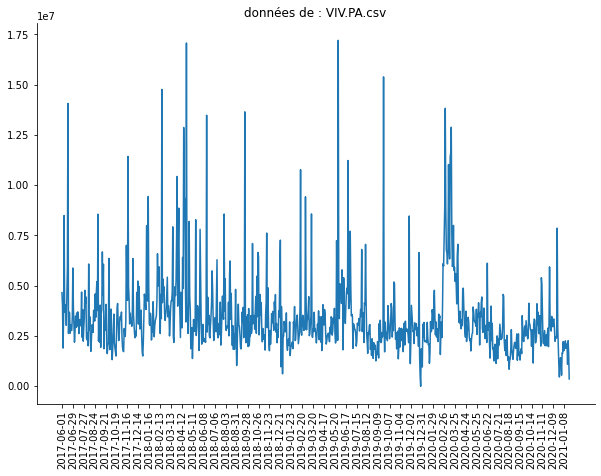

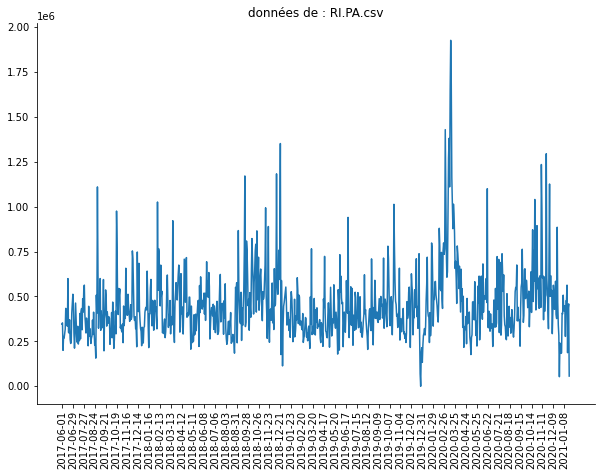

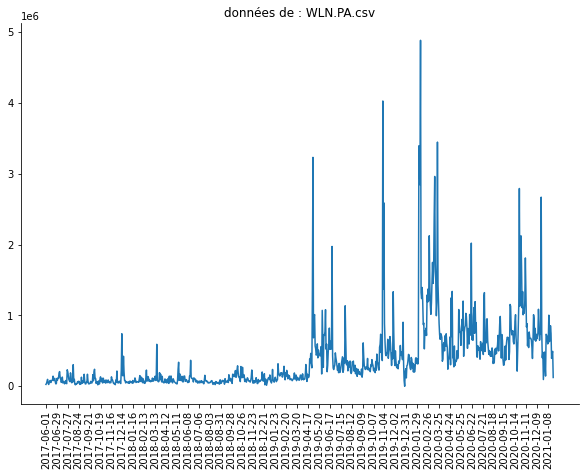

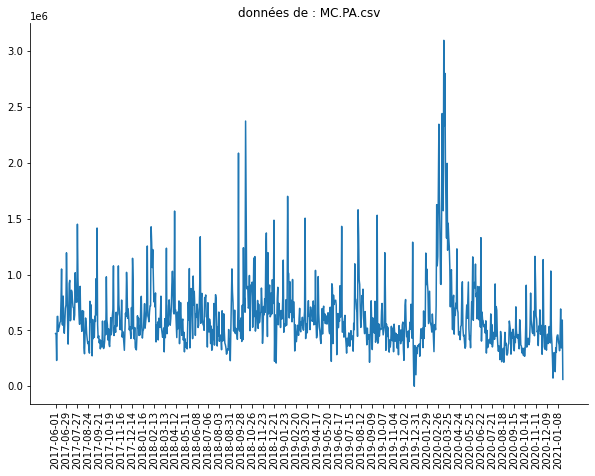

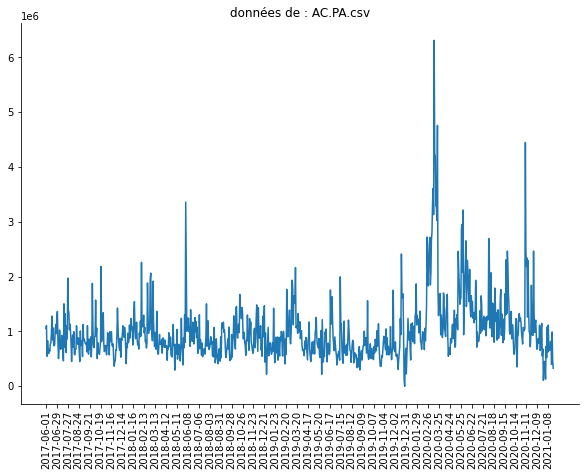

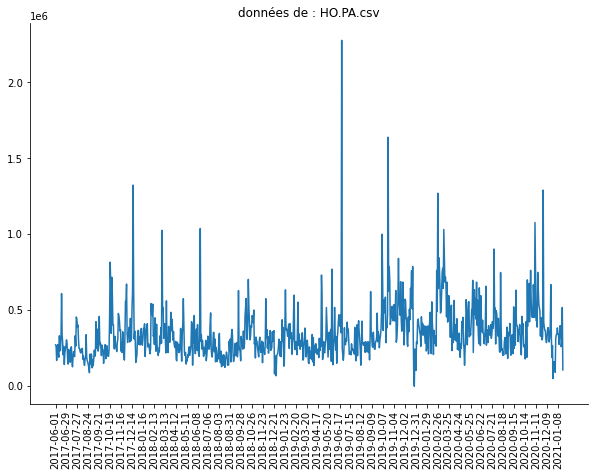

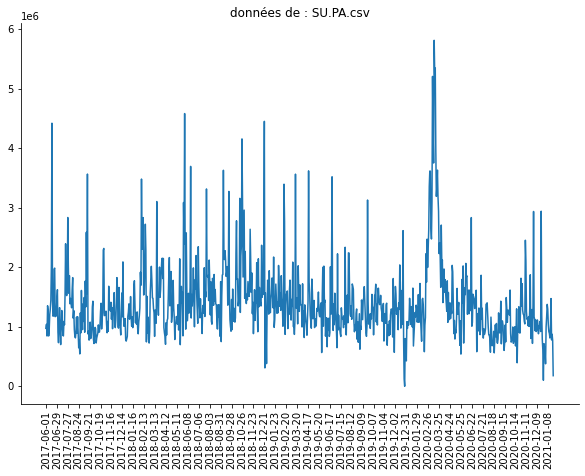

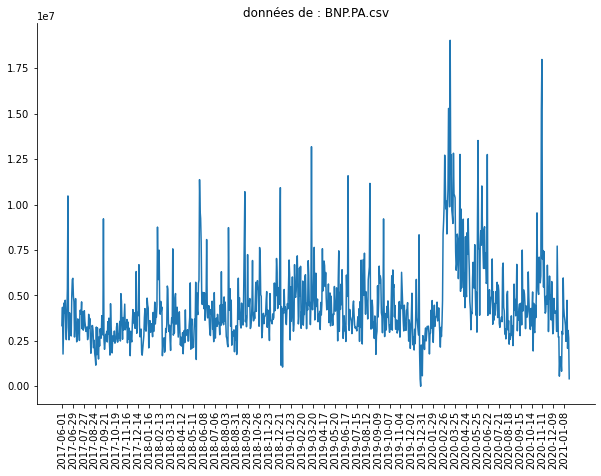

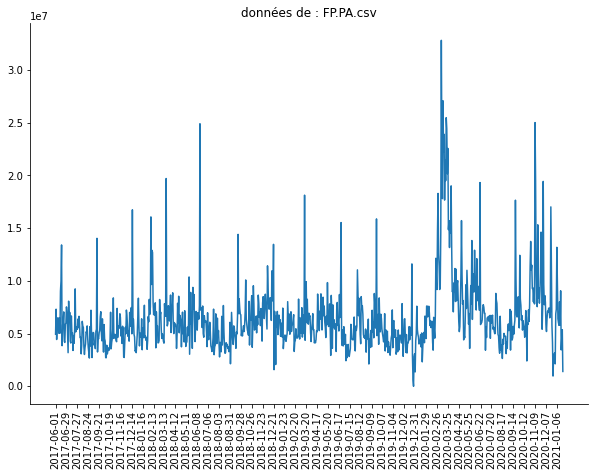

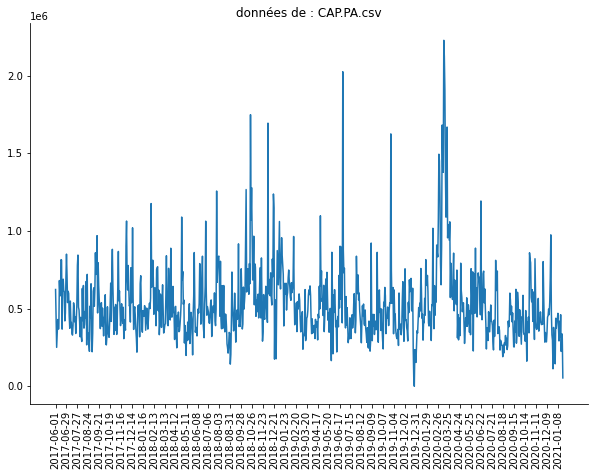

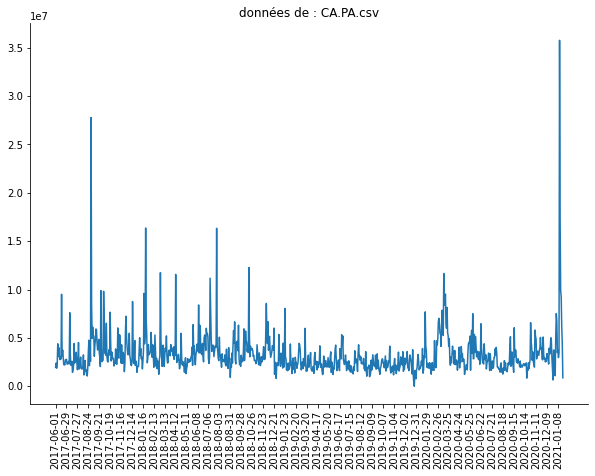

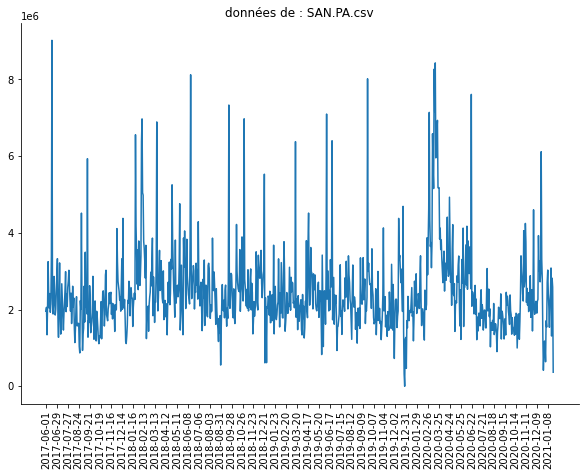

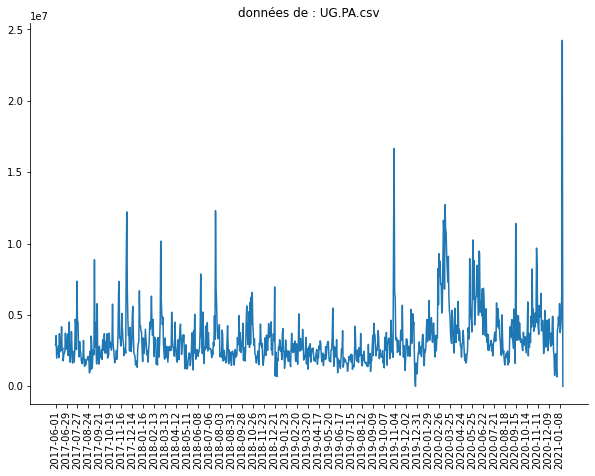

In [3]:
##########################################################################
# contenu du dossier :  DonCAC40
Liste_donnees=os.listdir('./DonCAC40')

for i in range(len(Liste_donnees)):
    F='./DonCAC40/'+Liste_donnees[i]
    data = pd.read_csv(F, delimiter=',')
    #data=data.dropna()  # supprimer les données manquantes
    data=data[data[data.columns[5]].notnull()]  ## supprimer les données manquantes
    data=data[(data[data.columns[0]] >='2017-06-01')] ## Sélectionner les données à partir du 1er juin 2017
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    # cacher axes  'haut' et 'droit':
    for side in ['right','top']:
        ax.spines[side].set_visible(False)
     
    T=len(data)
    plt.plot([i for i in range(T)],data[data.columns[5]])
    
    ## affichage l'axe des x
    ensemble_date=[data[data.columns[0]].values[i] for i in range(T) if i%20==0]
    plt.xticks([i for i in range(T) if i%20==0], 
               [ensemble_date[i] for i in range(len(ensemble_date))],
               size=10,rotation='vertical')
    
    plt.title("données de : %s"%Liste_donnees[i])
    plt.show()

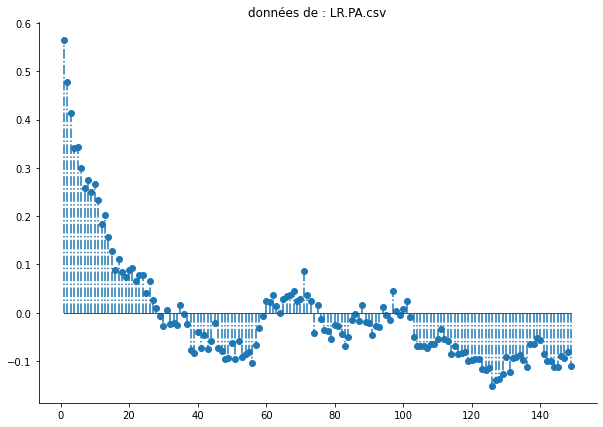

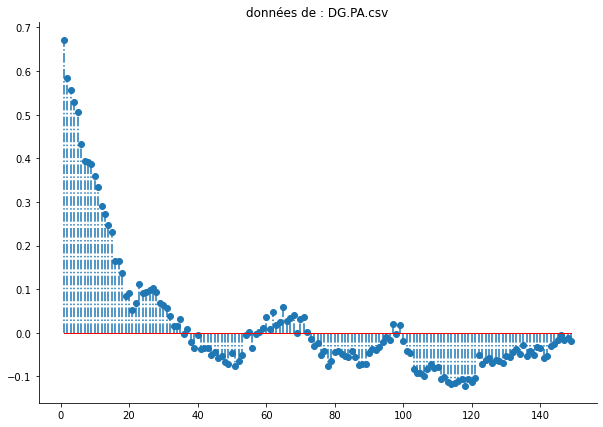

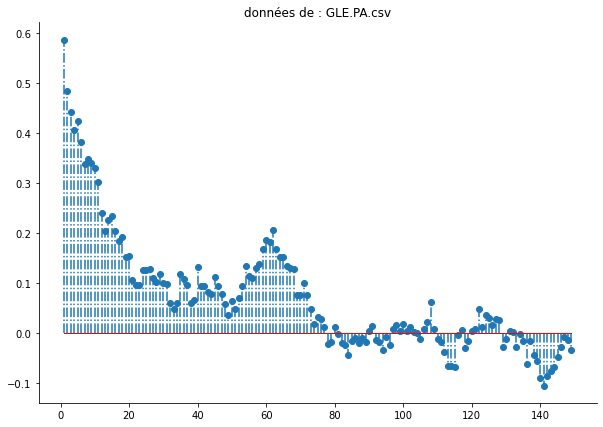

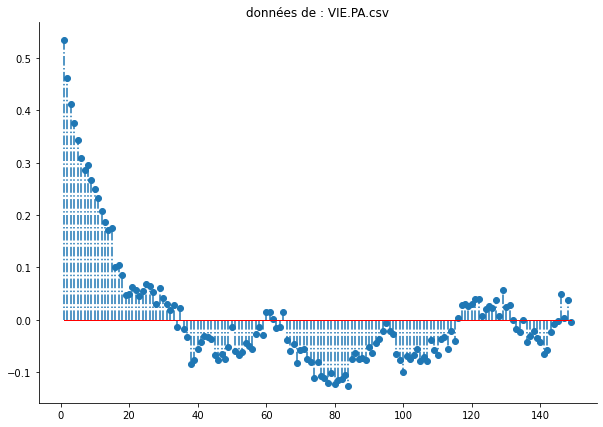

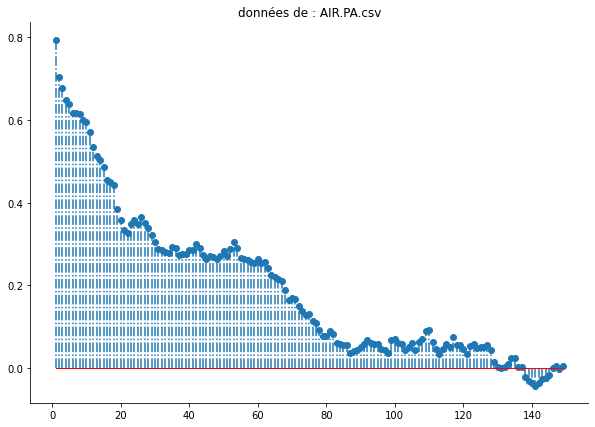

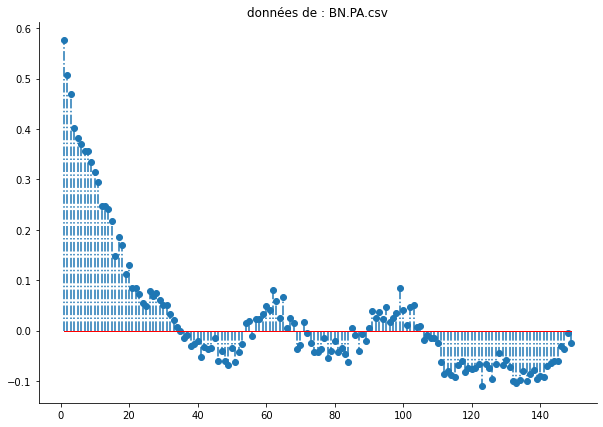

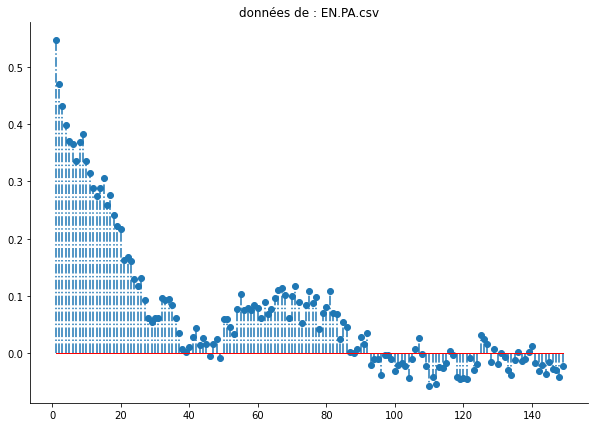

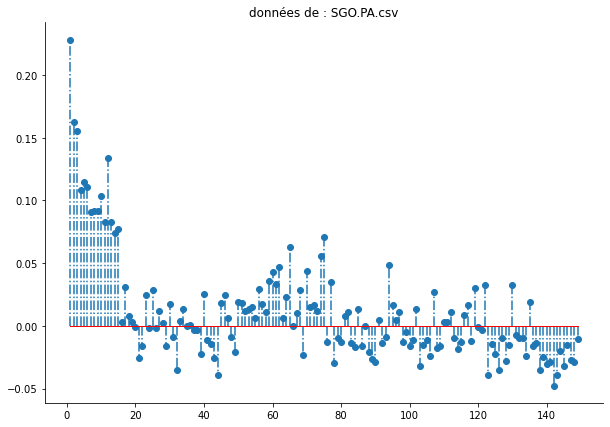

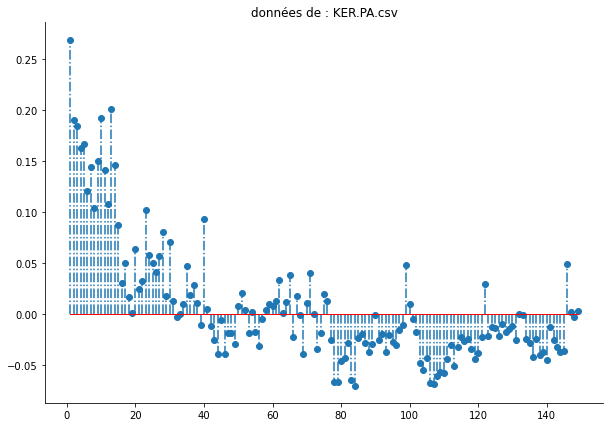

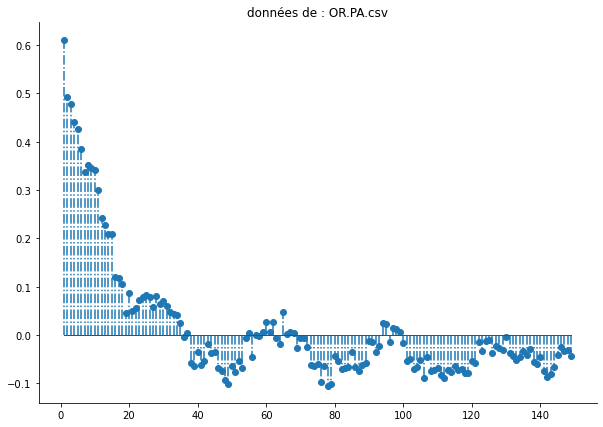

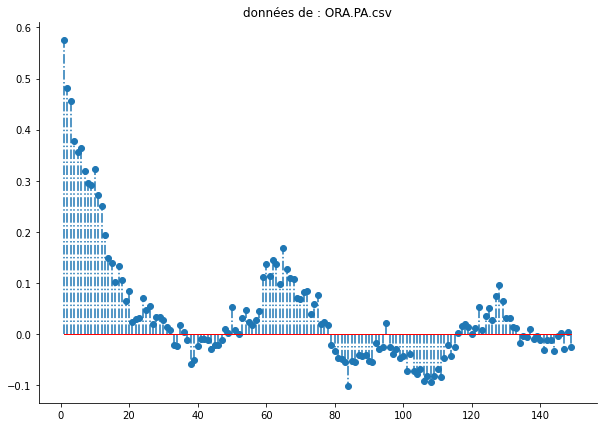

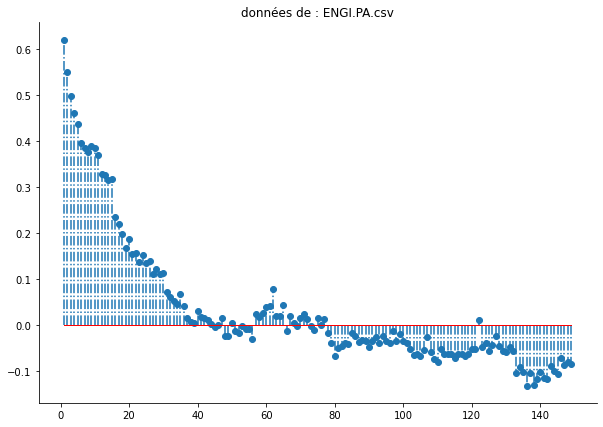

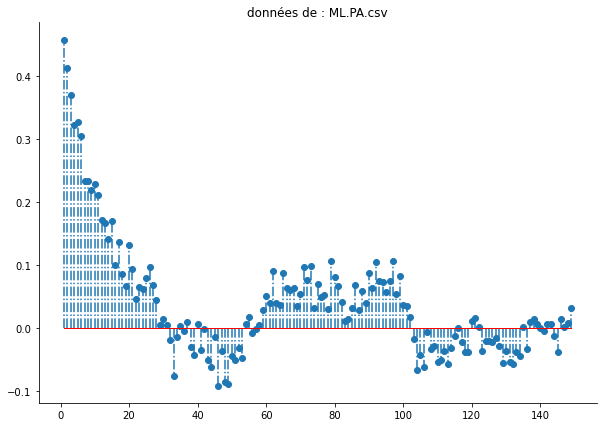

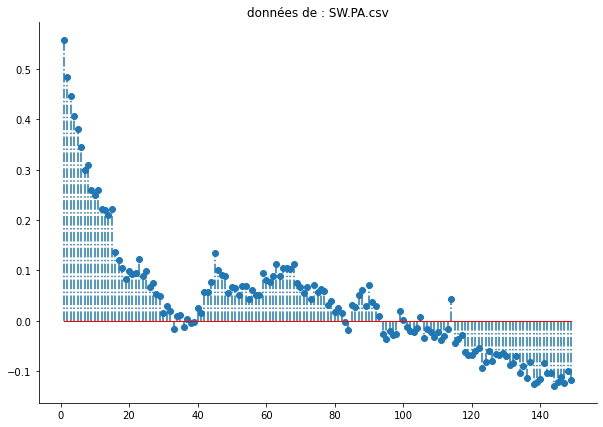

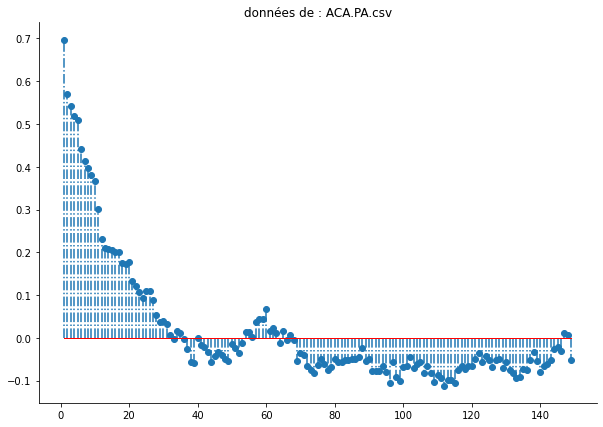

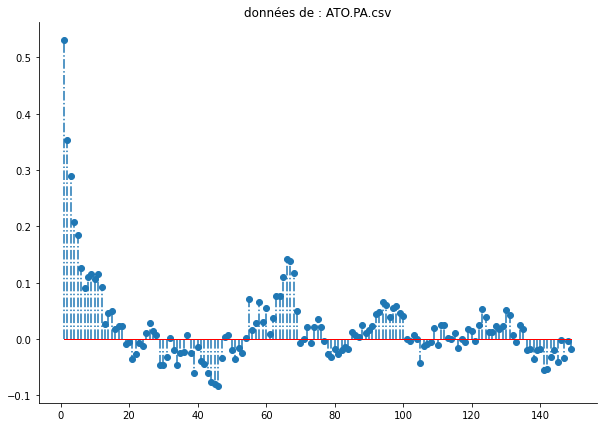

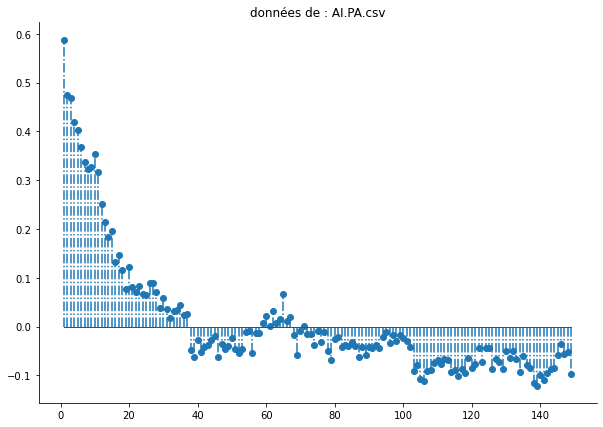

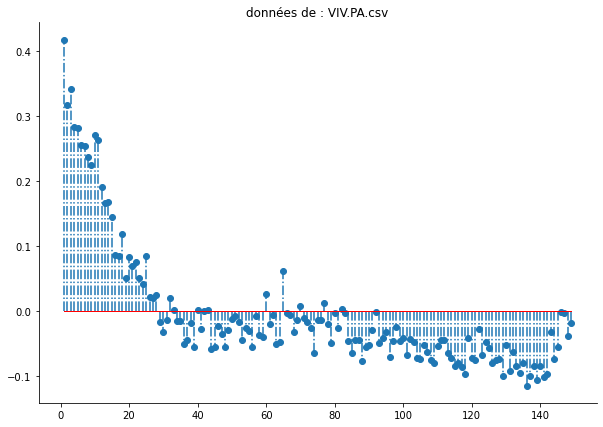

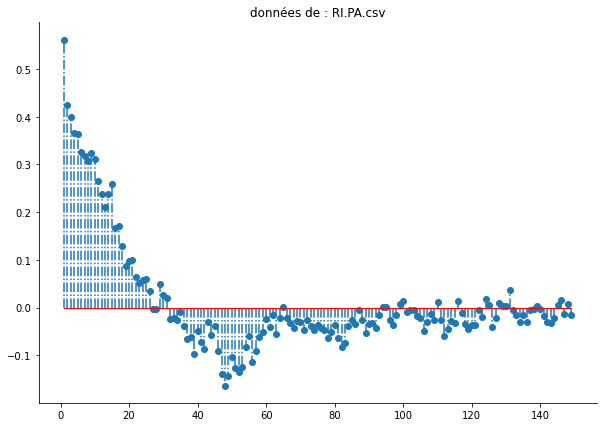

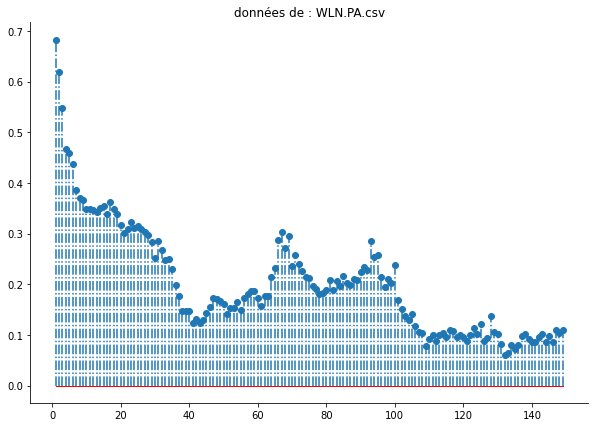

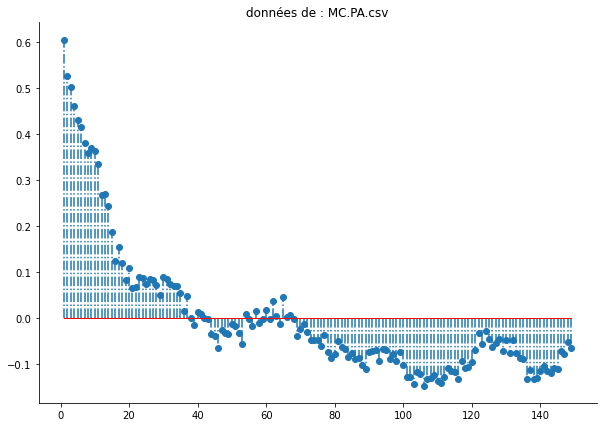

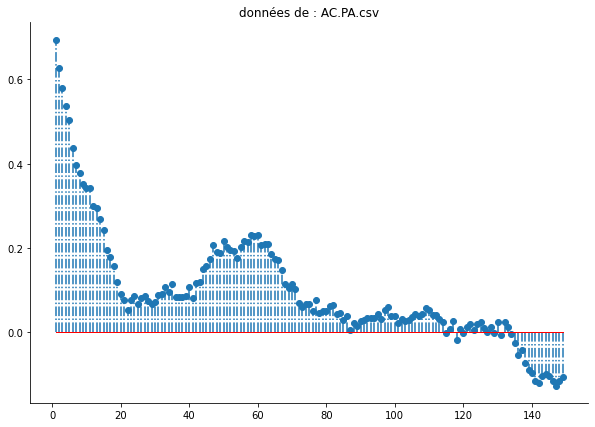

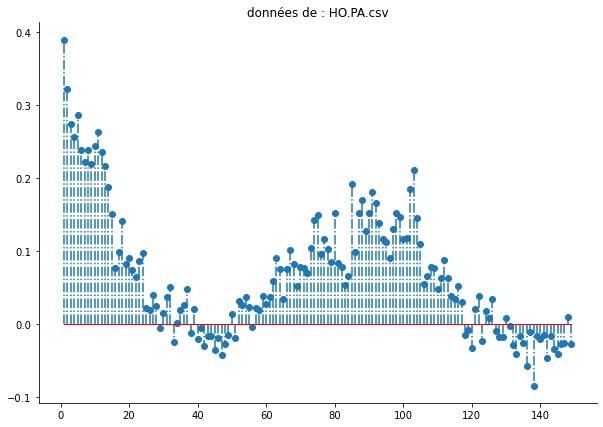

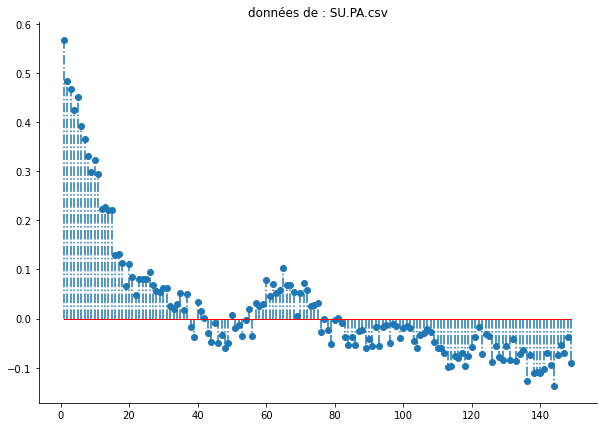

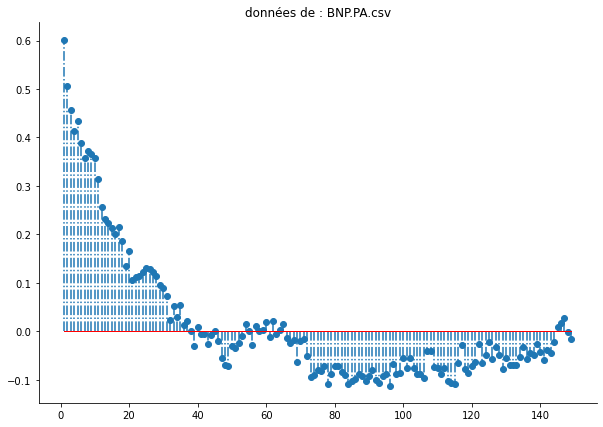

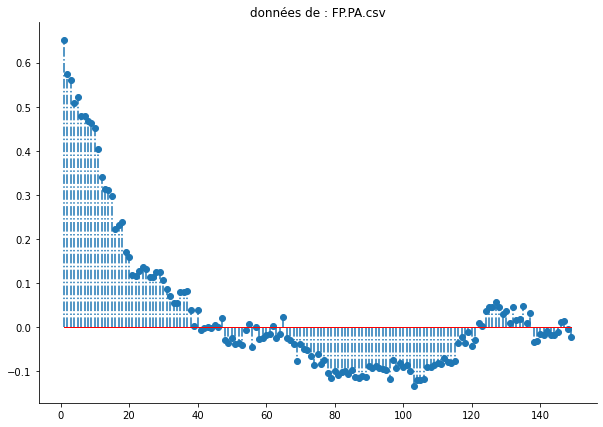

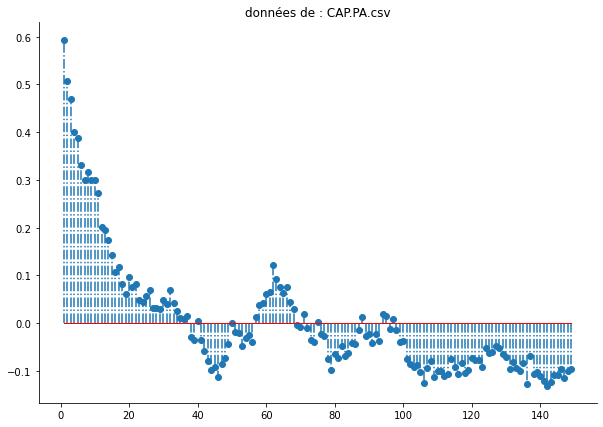

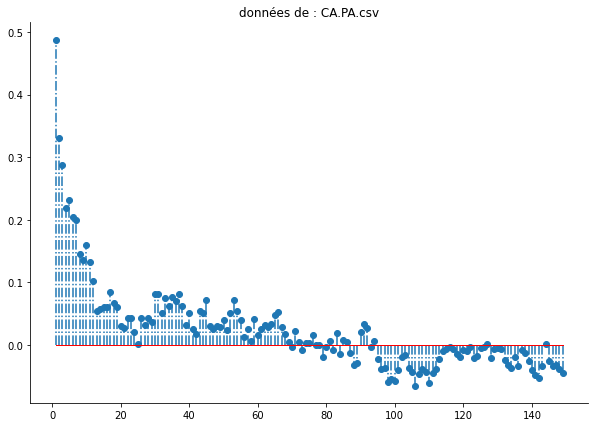

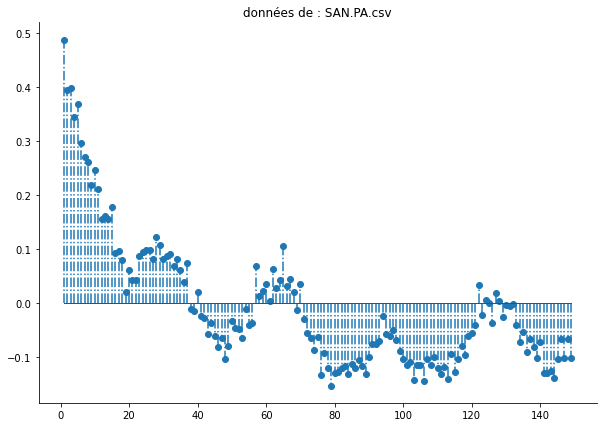

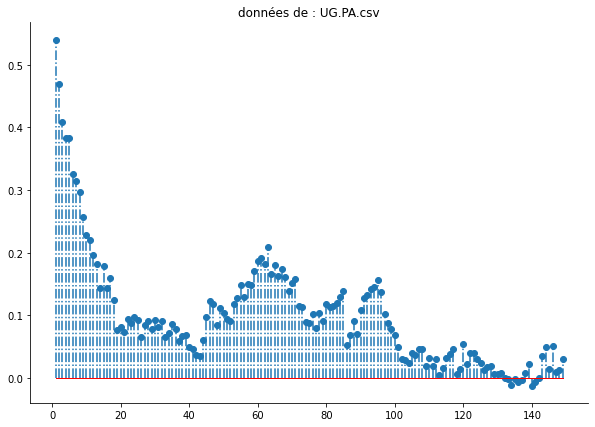

In [4]:
##########################################################################
# contenu du dossier :  DonCAC40
Liste_donnees=os.listdir('./DonCAC40')

for i in range(len(Liste_donnees)):
    F='./DonCAC40/'+Liste_donnees[i]
    data = pd.read_csv(F, delimiter=',')
    #data=data.dropna()  # supprimer les données manquantes
    data=data[data[data.columns[5]].notnull()]  ## supprimer les données manquantes
    data=data[(data[data.columns[0]] >='2017-06-01')] ## Sélectionner les données à partir du 1er juin 2017
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    # cacher axes  'haut' et 'droit':
    for side in ['right','top']:
        ax.spines[side].set_visible(False)
     
    T=len(data)
    k = np.arange(1,150,1) 
    ACF=[TM_ACF(data[data.columns[5]][250:],lag=j) for j in k]

    markerline, stemlines, baseline = plt.stem(k, ACF, '-.')
    plt.setp(baseline, 'color', 'r', 'linewidth', 1)
    
    plt.title("données de : %s"%Liste_donnees[i])
    plt.show()

## Implémentation de la méthode

In [5]:
## Load et plot les Ième données
# args : i ième jeu de données
# return : dataframe des données avec seulement Adj Close
def load_data(i):
    F='./DonCAC40/'+Liste_donnees[i]
    data = pd.read_csv(F, delimiter=',')
    #data=data.dropna()  # supprimer les données manquantes
    data=data[data[data.columns[5]].notnull()]  ## supprimer les données manquantes
    data=data[(data[data.columns[0]] >='2017-06-01')] ## Sélectionner les données à partir du 1er juin 2017
    
    return data[['Date', 'Adj Close']]

In [6]:
# Transforme les données en la quantité qui nous intéresse (qui elle suit une loi de Weibull avec rupture)
def transform_data(data):
    X = data.values
    Y=[ log(1+ (X[i]/X[i-1])) for i in range(1,len(X)) ]
    
    #y= [0 for _ in range(len(X)-1)]
    #for i in range(1,len(X)):
       # y[i-1]=log(1+X[i]/X[i-1])
    df = pd.DataFrame(Y, columns=["Transformed"])
    return df

In [7]:
#Sépare les données (transformées) pour en faire deux sous échantillions (que l'ont ordonne ensuite) selon k
#args: data un dataframe avec une colonne "Transformed", k un entier entre 4 et len(data) - 4
#return deux dataframe des sous échantillions odronnées
def split_data(data, k):
    sample_1 = data[:k].sort_values(by=["Transformed"])
    sample_2 = data[k:].sort_values(by=["Transformed"])
    return (sample_1, sample_2)

In [8]:
#Calcul les approximations des Median Rank par l'approximation de Benard
#args: k l'entier de rupture, n la taille des données disponibles
#return : deux listes de MR (les MR sur le 1er sous échantillion et les MR sur le 2em)
def compute_MR(k, n):
    MR_1 = []
    MR_2 = []
    for i in range(1, k+1):
        MR_1.append((i - 0.3)/(k + 0.4)) 

    for i in range(k+1, n+1):
        MR_2.append((i-k - 0.3)/(n-k + 0.4))
    return (MR_1, MR_2)

#Clacule les Y_i (équation (11)) approchant la loi de répartition à partir des MR
#args : MR_1 liste des median rank du 1er échantillion, MR_2 liste des median rank du 2em echantillion,
#k le point de rupture
#return : Deux liste des loi de répartition, une pour chaque sous échantillion 
def compute_cum_dist(MR_1, MR_2, k):
    Y_1 = []
    Y_2 = []
    
    for mr in MR_1:
        Y_1.append(np.log(-np.log(1-mr)))
    for mr in MR_2:
        Y_2.append(np.log(-np.log(1-mr)))
    
    return (Y_1,Y_2)

In [9]:
import scipy.stats as st

#Plutôt que de faire le calcul explicite des paramètres approchées données dans (9) (10) (11) on effectue une
#régression linéaire sur le logarithme des données transformées pour être plus léger à écrire
#On obtient les bons résultats par la suite sur k uniquemement si on prend la MOYENNE de lerreur quadratique de
#la régression plutôt que simplement l'erreur quadratique comme décrit dans l'article


#Calcul la régression linéaire des Y_i calculé par la fonction de réparition approchée et le LOGARITHME des
#données transformées.
#args : Y liste des valeurs calculées à partir de la fonction de réparition approchées, X liste des valeurs
#des LOGARITHMES des données transformées, plot booléen qui plot ou non la regression linéaire faite
#return : la constante, la pente et la moyenne de l'erreur quadratique de la régression
def lin_reg(Y, X, plot=1):
    linreg = st.linregress(X, Y)
    if(plot == 1):
        plt.clf()
        plt.plot(X, Y, 'o')
        plt.plot(X, linreg.intercept + linreg.slope*X, 'r')
        plt.show()
    
    err =  np.power((Y - (linreg.intercept + linreg.slope*X)),2)
    
    #return (linreg.intercept, linreg.slope, np.mean(err))
    return (linreg.intercept, linreg.slope, np.sum(err) )
    #return (linreg.intercept, linreg.slope, linreg.stderr)
    

In [10]:
#Calcule les paramètres des deux modèles linéaires sur les données transformées au point de rupture k
#args: data les données transformée, k le poitn de rupture, plot un bolléen si on veut plot les 2 régressions
#return: un coupe contanant la constante de la 1er régression et la constante de la deuxième, un couple
# contenant la pente de la 1ere régression et la pente de la 2ème régression, l'erreur totale qui est la sommme
# des mean square error des deux regressions

def compute_param(data, k, plot=0):
    
    MR_1, MR_2 = compute_MR(k, len(data.index))
    
    data_1, data_2 = compute_cum_dist(MR_1, MR_2, k)
    
    data_transformed_1, data_transformed_2 = split_data(data, k)
    
    b1, a1, err1 = lin_reg(data_1, np.log(data_transformed_1["Transformed"].to_numpy()), plot)
    b2, a2, err2 = lin_reg(data_2, np.log(data_transformed_2["Transformed"].to_numpy()), plot)
    
    err_total = err1 + err2
    return ((b1,b2),(a1,a2),err_total)
 
# Calcul les paramètres des lois de Weibull et le point de rupture k
# args : data les données transformée , n la taille des données transformée
# return un couple contenant le paramètre b des loi de Weibull, un couple contenant les paramètres a des loi de
# Weibull et le meilleur k
def compute_best_param(data, n):
    best_err = 10000
    best_a = (0, 0)
    best_b = (0, 0)
    best_k = 0
    err=[]
    for k in range(4, n - 4 + 1):
        b,a,err_total =compute_param(data, k)
        err.append(err_total)
        if(err_total <= best_err):
            best_err = err_total
            best_a = a
            best_b = b
            best_k = k
    
    b_hat_1 = best_a[0]
    a_hat_1 = np.exp(-best_b[0]/b_hat_1)
    b_hat_2 = best_a[1]
    a_hat_2 = np.exp(-best_b[1]/b_hat_2)
    
    return ((b_hat_1, b_hat_2), (a_hat_1, a_hat_2),best_k,err)

## Fonction d'affichages

In [11]:
# afficher les données boursières des données en fonction du temps
# arguments: data un dataframe ayant pour première colonne les dates et commme seconde colonnes les valeurs 
#            que l'on souhaite afficher
#            date l'indice de la date de rupture que l'on va afficher
#            title le titre du graphique

def plot(data,date,title):
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    # cacher axes  'haut' et 'droit':
    for side in ['right','top']:
        ax.spines[side].set_visible(False)
     
    T=len(data)
    plt.plot([i for i in range(T)],data[data.columns[1]])
    
    ## affichage l'axe des x
    ensemble_date=[data[data.columns[0]].values[i] for i in range(T) if i%20==0]
    plt.xticks([i for i in range(T) if i%20==0], 
               [ensemble_date[i] for i in range(len(ensemble_date))],
               size=10,rotation='vertical')
    
    plt.title(title+ "%s"%Liste_donnees[i])
    
    plt.axvline(x=date,color='r')
            
    plt.show()

In [12]:
# afficher l'erreur quadratique pour un modéle
# arguments: erreur la liste des erreur quadratique
#            list_date la liste des date compléte
#            n et first_index permettent de découper list_date afin d'avoir la bonne longueur de liste
#            k l'indice de la date de rupture que l'on va afficher
#            title le tritre du graphique que l'on va afficher

def print_error(err,list_date,k,n,first_index,title):
    
    list_index=[list_date[i] for i in range(first_index+4, first_index+n - 4 + 1)]
    
    error=pd.DataFrame(err, columns=["error"])
    error.insert(0, 'Date', list_index, allow_duplicates=False)
    plot(error,k,title)

## résultats

In [13]:
# faire tourner le modéle et afficher les paramétres du modéle, les graphiques des erreurs et de la valeur 
# des actions en fonction du temps
def estimate_rupture(i):
    
    #élaboration du modéle
    data = load_data(i)
    data_transformed = transform_data(data['Adj Close'])
    n=len(data_transformed.index)
    b, a, k,err = compute_best_param(data_transformed,n) 
    
    #obtenir la date de rupture
    list_date=data['Date'][1:len(data.index)]
    date=list_date[k+data.index[0]]
    
    #présentation des résultats
    
    print("*"*30)
    print('Etude de: {}'.format(Liste_donnees[i]))
    print("*"*30)
    print("\n")
    
    print("Les paramétres calculés:")
    
    print("- les paramétres de la première loi: a1={} b1={}".format(round(a[0],3),round(b[0],3)))
    print("- les paramétres de la sedonde loi: a2={} b2={}".format(round(a[1],3),round(b[1],3)))
    print("- la date de rupture est le {}".format(date))
    print("\n")
    
    print("graphiques")
    
    plot(data,k+1,"donnée de:")
    print_error(err,list_date,k,n,data.index[0],"somme des erreurs au carré de: ")
    

******************************
Etude de: LR.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=153.063
- les paramétres de la sedonde loi: a2=0.7 b2=64.361
- la date de rupture est le 2020-03-11


graphiques


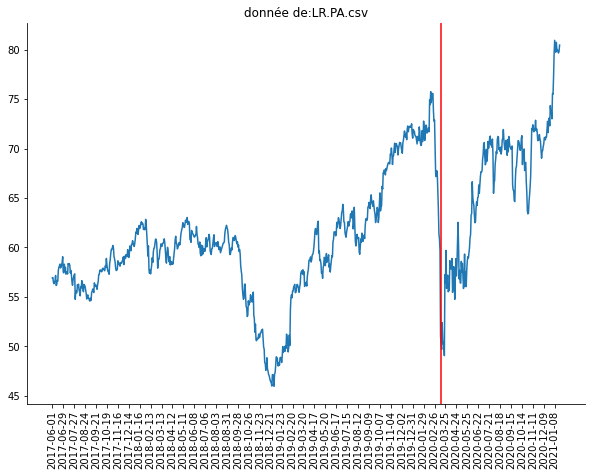

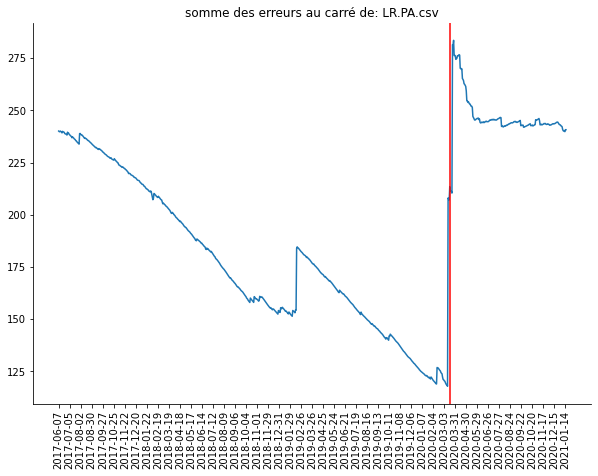

******************************
Etude de: DG.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=150.858
- les paramétres de la sedonde loi: a2=0.702 b2=45.357
- la date de rupture est le 2020-03-06


graphiques


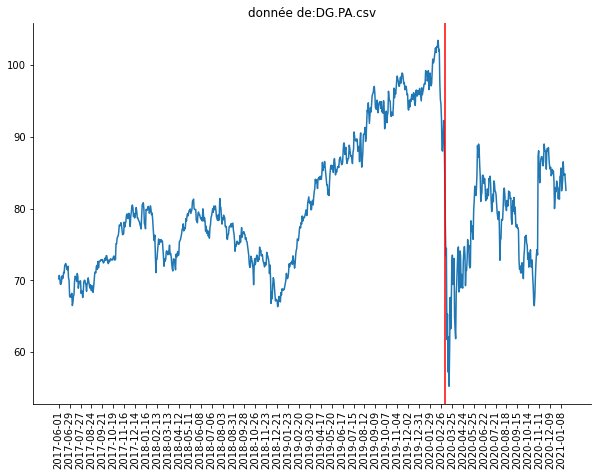

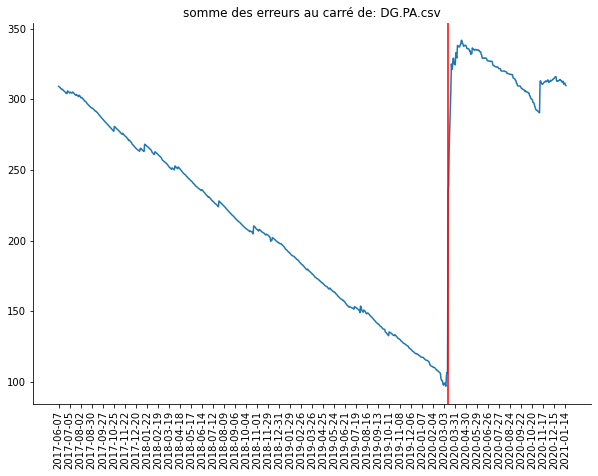

******************************
Etude de: GLE.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=112.322
- les paramétres de la sedonde loi: a2=0.705 b2=34.086
- la date de rupture est le 2020-03-06


graphiques


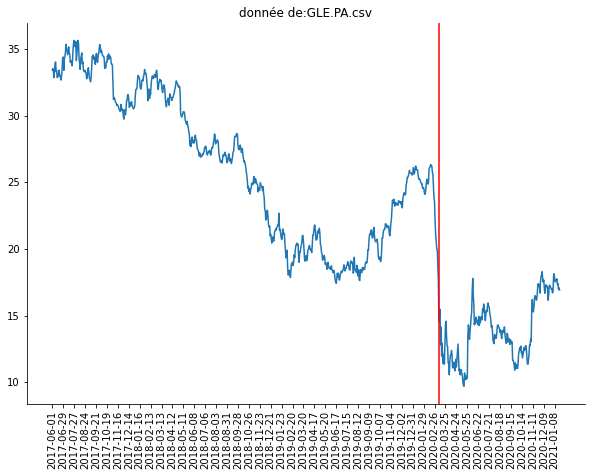

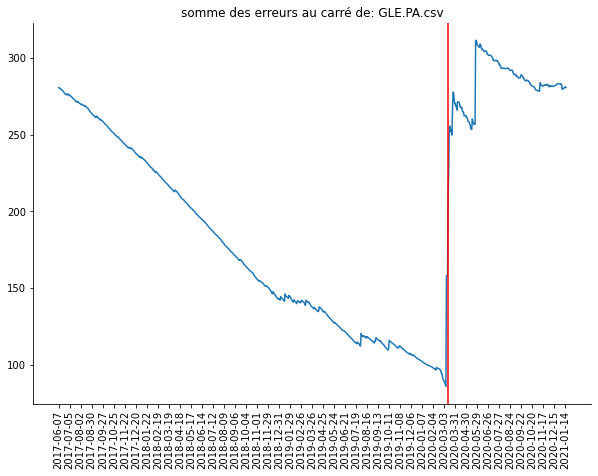

******************************
Etude de: VIE.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=163.49
- les paramétres de la sedonde loi: a2=0.699 b2=60.358
- la date de rupture est le 2020-02-28


graphiques


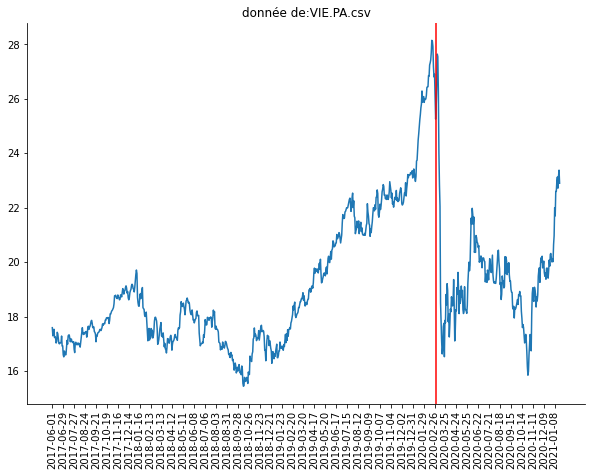

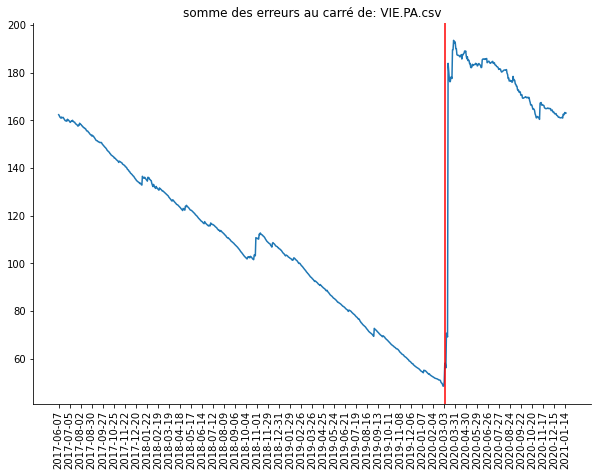

******************************
Etude de: AIR.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.697 b1=102.987
- les paramétres de la sedonde loi: a2=0.705 b2=33.826
- la date de rupture est le 2020-03-11


graphiques


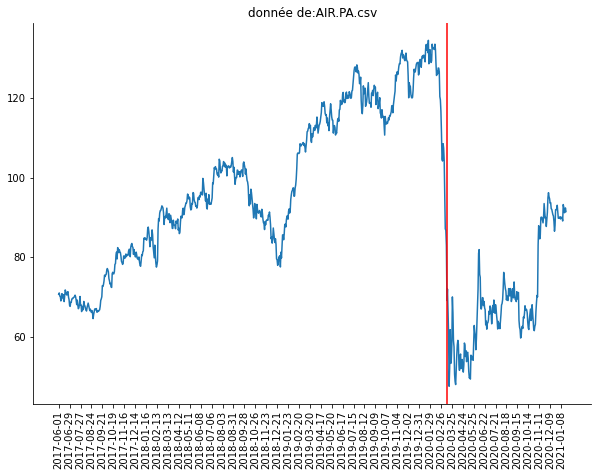

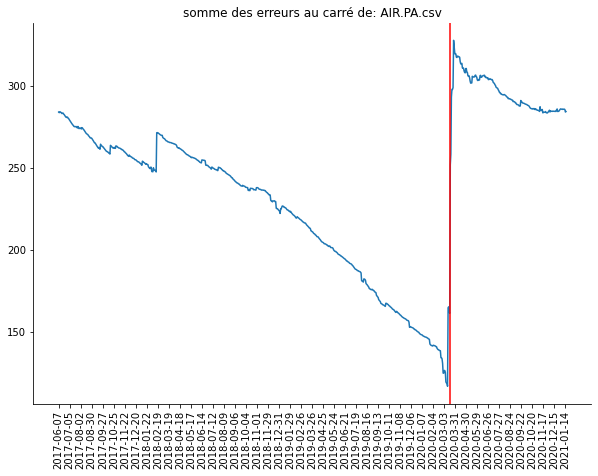

******************************
Etude de: BN.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=163.018
- les paramétres de la sedonde loi: a2=0.698 b2=87.334
- la date de rupture est le 2020-03-11


graphiques


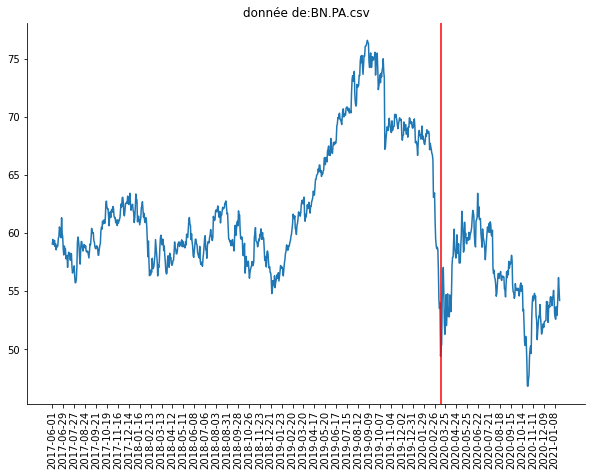

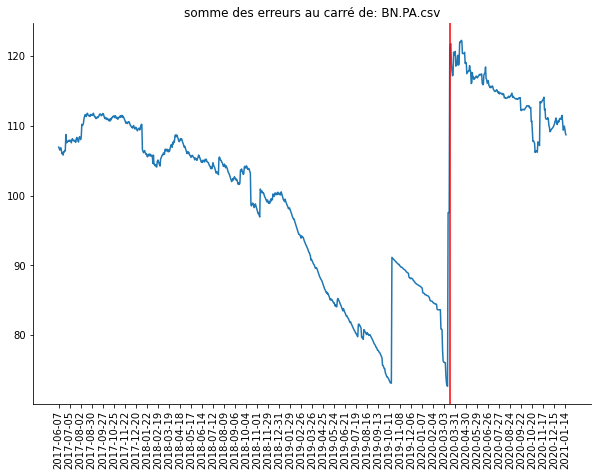

******************************
Etude de: EN.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.697 b1=113.592
- les paramétres de la sedonde loi: a2=0.702 b2=48.958
- la date de rupture est le 2020-03-11


graphiques


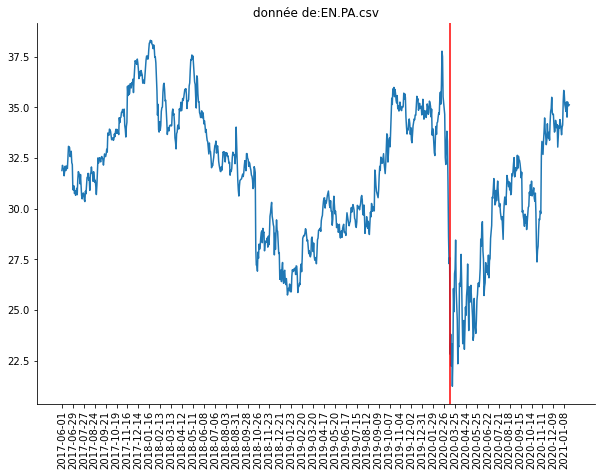

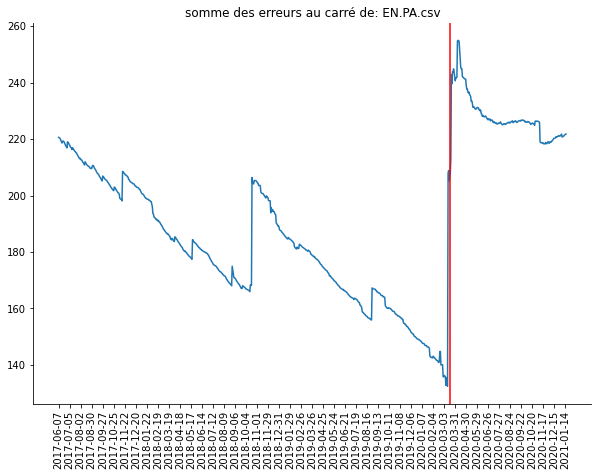

******************************
Etude de: SGO.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=123.391
- les paramétres de la sedonde loi: a2=0.702 b2=50.271
- la date de rupture est le 2020-03-11


graphiques


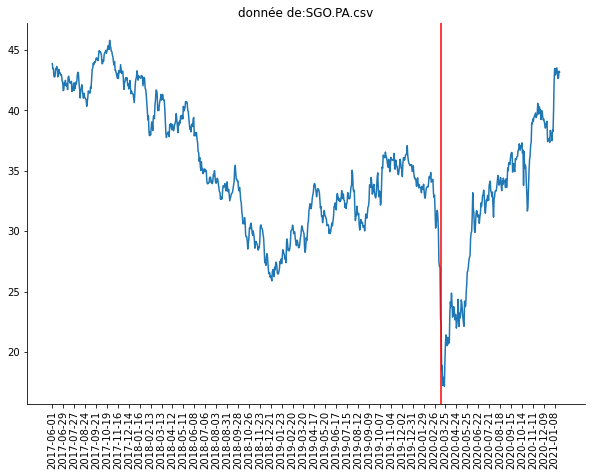

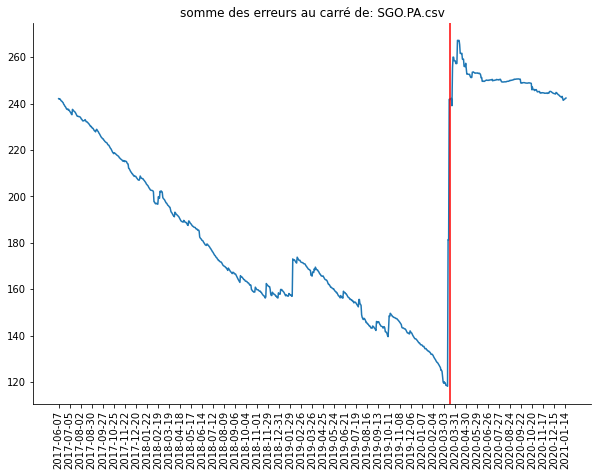

******************************
Etude de: KER.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.697 b1=162.502
- les paramétres de la sedonde loi: a2=0.698 b2=80.073
- la date de rupture est le 2017-10-24


graphiques


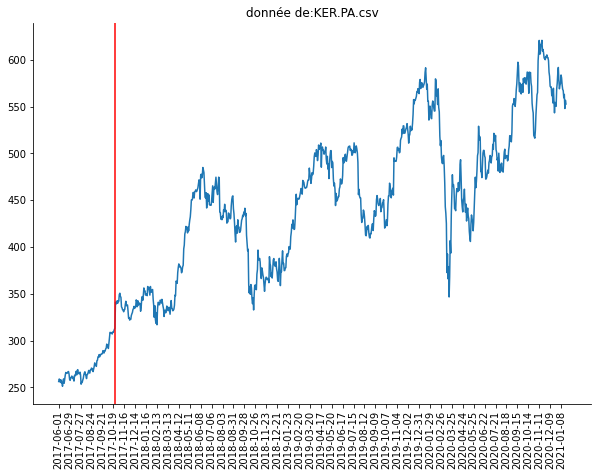

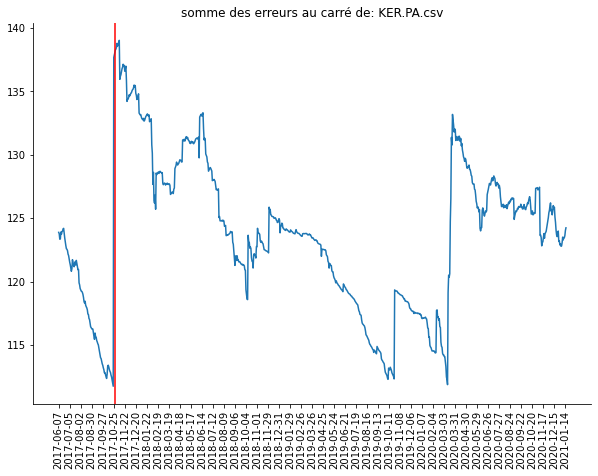

******************************
Etude de: OR.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=157.243
- les paramétres de la sedonde loi: a2=0.698 b2=90.673
- la date de rupture est le 2019-10-29


graphiques


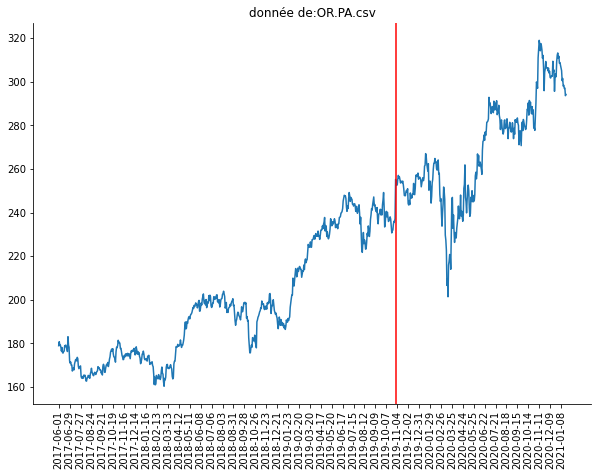

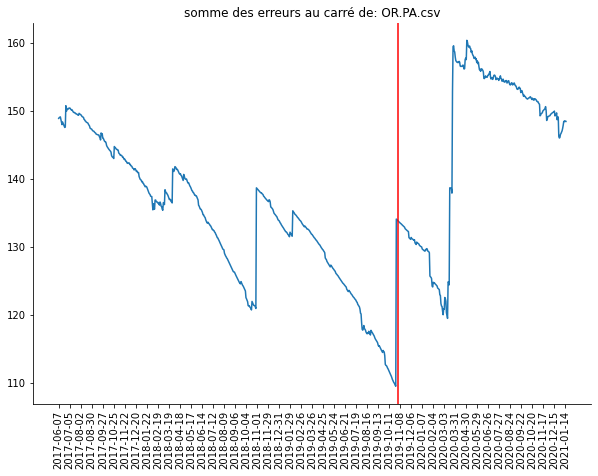

******************************
Etude de: ORA.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.695 b1=188.873
- les paramétres de la sedonde loi: a2=0.698 b2=77.862
- la date de rupture est le 2020-03-02


graphiques


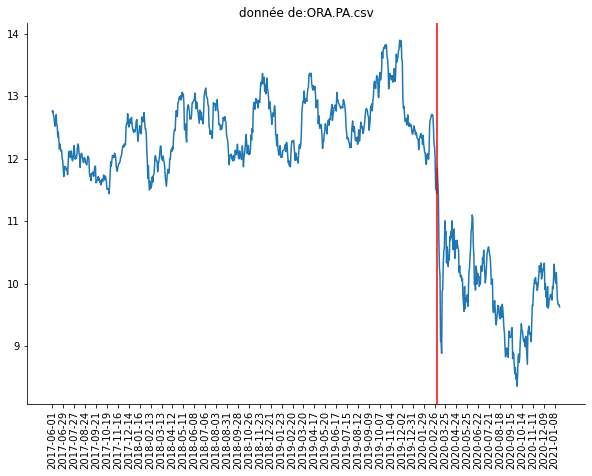

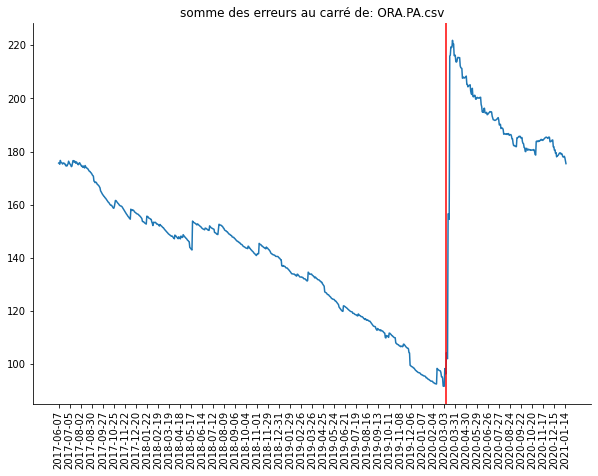

******************************
Etude de: ENGI.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=148.36
- les paramétres de la sedonde loi: a2=0.7 b2=57.417
- la date de rupture est le 2020-03-03


graphiques


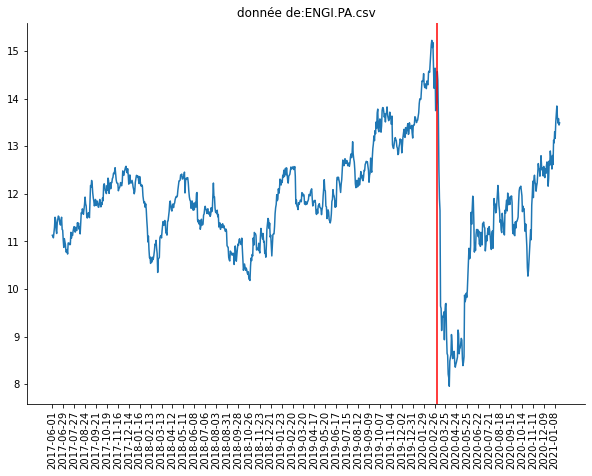

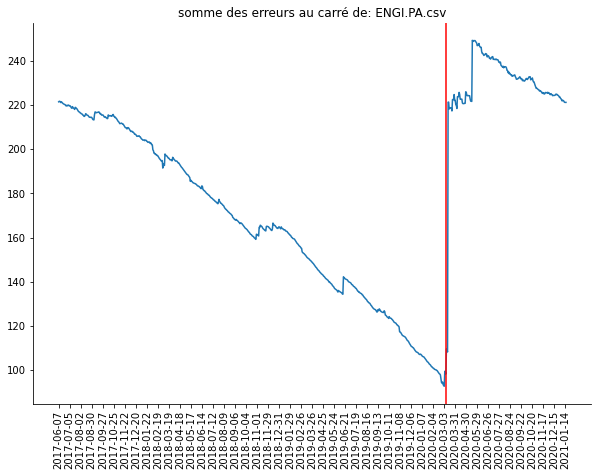

******************************
Etude de: ML.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=140.497
- les paramétres de la sedonde loi: a2=0.698 b2=77.361
- la date de rupture est le 2018-10-15


graphiques


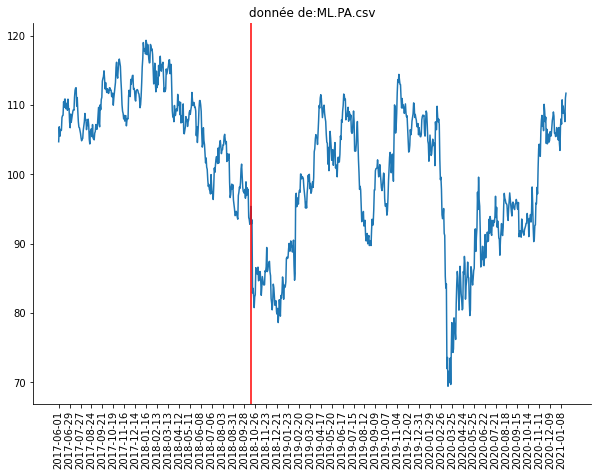

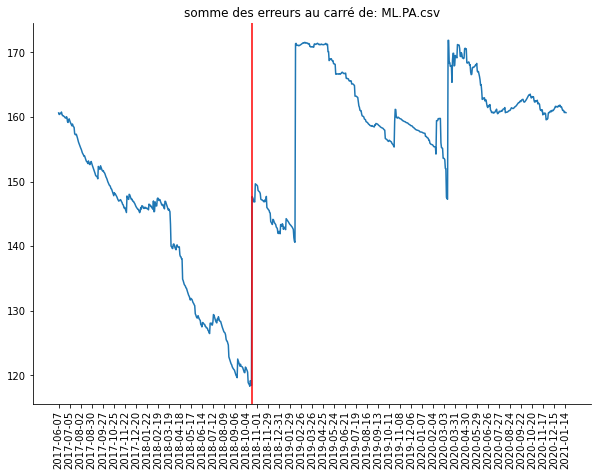

******************************
Etude de: SW.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=114.998
- les paramétres de la sedonde loi: a2=0.703 b2=43.027
- la date de rupture est le 2020-03-11


graphiques


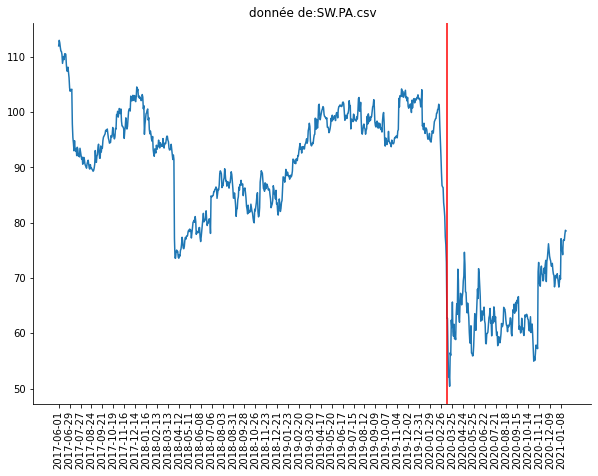

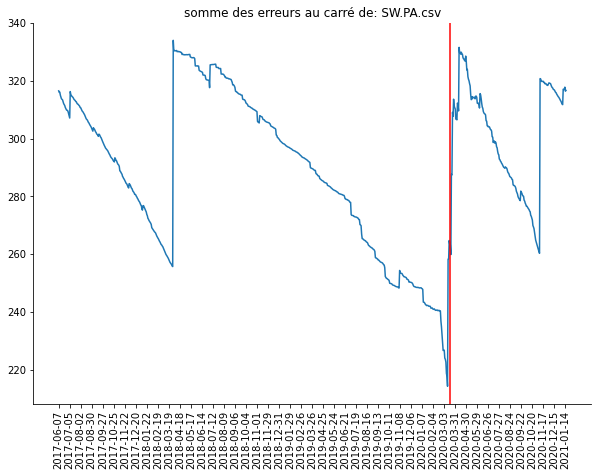

******************************
Etude de: ACA.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=119.041
- les paramétres de la sedonde loi: a2=0.702 b2=46.349
- la date de rupture est le 2020-03-06


graphiques


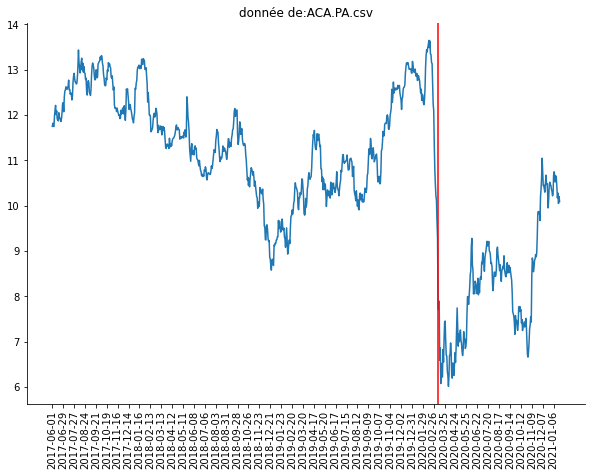

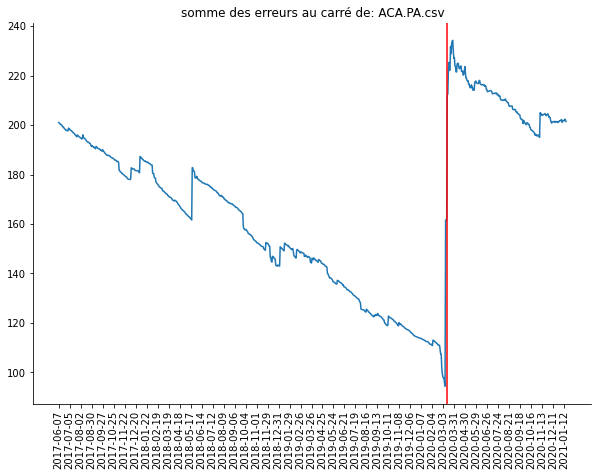

******************************
Etude de: ATO.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=125.066
- les paramétres de la sedonde loi: a2=0.699 b2=66.191
- la date de rupture est le 2018-05-30


graphiques


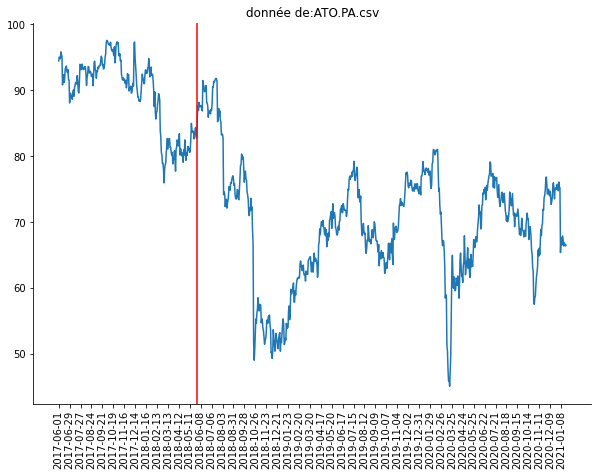

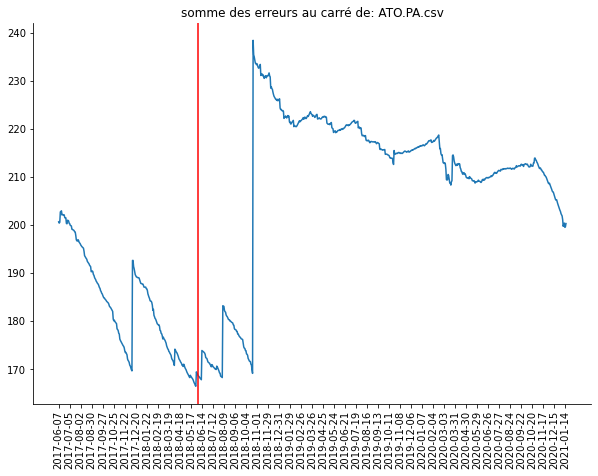

******************************
Etude de: AI.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=168.156
- les paramétres de la sedonde loi: a2=0.698 b2=84.384
- la date de rupture est le 2020-03-06


graphiques


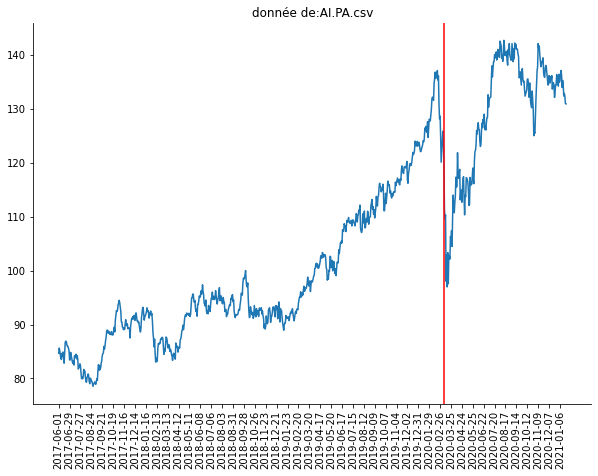

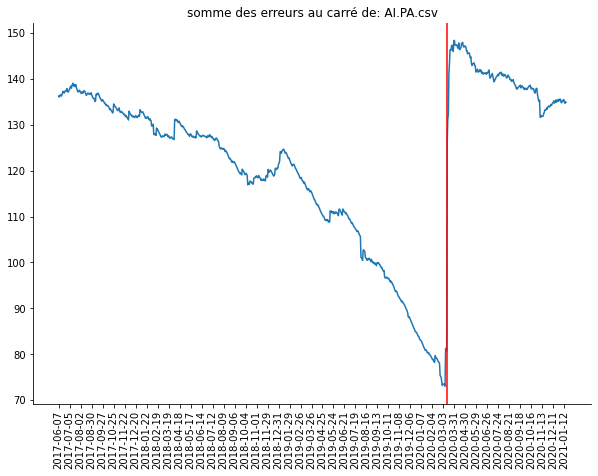

******************************
Etude de: VIV.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=127.681
- les paramétres de la sedonde loi: a2=0.699 b2=79.011
- la date de rupture est le 2020-03-10


graphiques


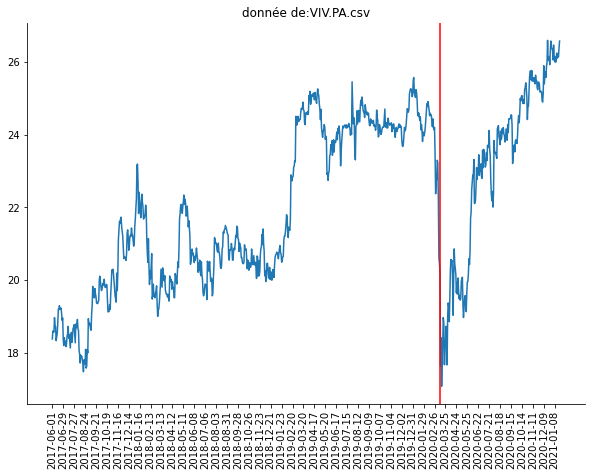

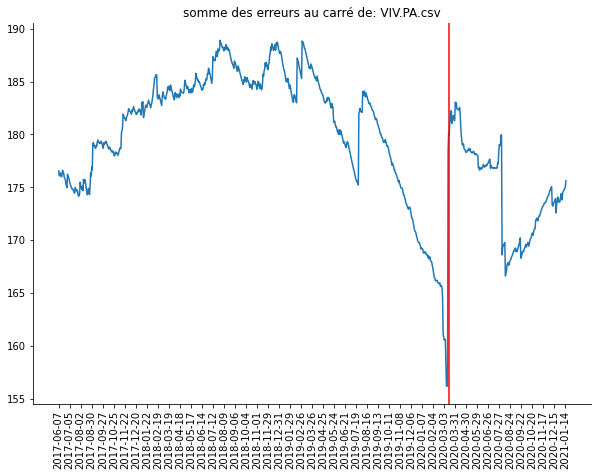

******************************
Etude de: RI.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.695 b1=188.847
- les paramétres de la sedonde loi: a2=0.697 b2=112.387
- la date de rupture est le 2018-12-10


graphiques


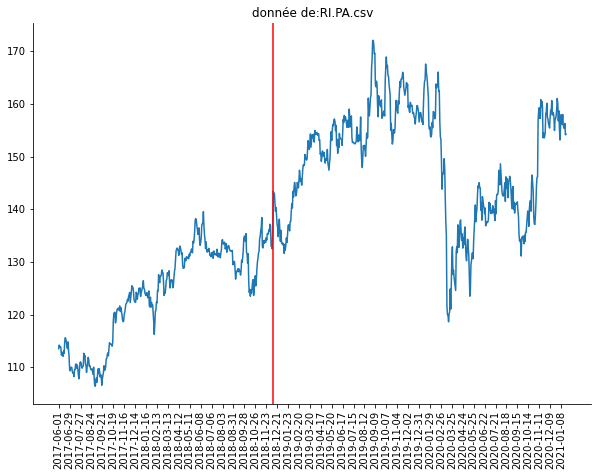

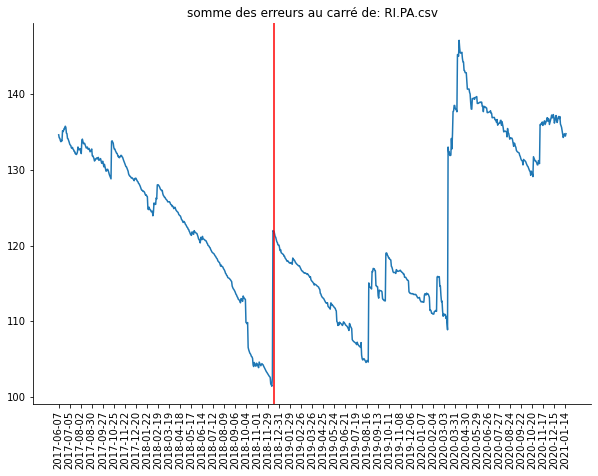

******************************
Etude de: WLN.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.698 b1=85.697
- les paramétres de la sedonde loi: a2=0.702 b2=50.655
- la date de rupture est le 2020-03-13


graphiques


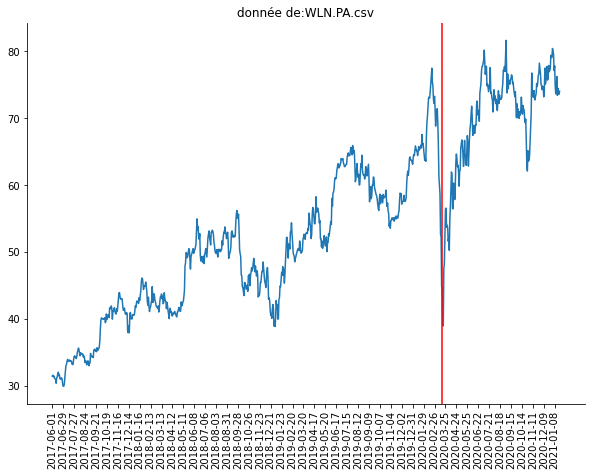

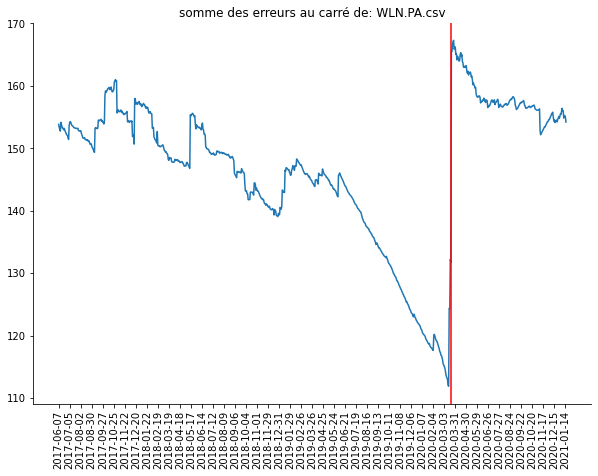

******************************
Etude de: MC.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.697 b1=114.168
- les paramétres de la sedonde loi: a2=0.7 b2=72.834
- la date de rupture est le 2020-03-11


graphiques


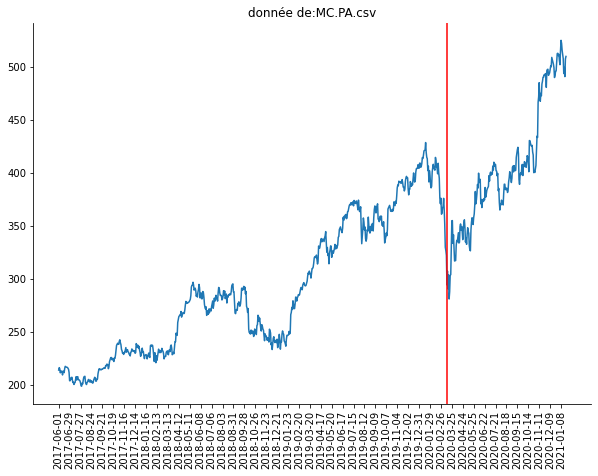

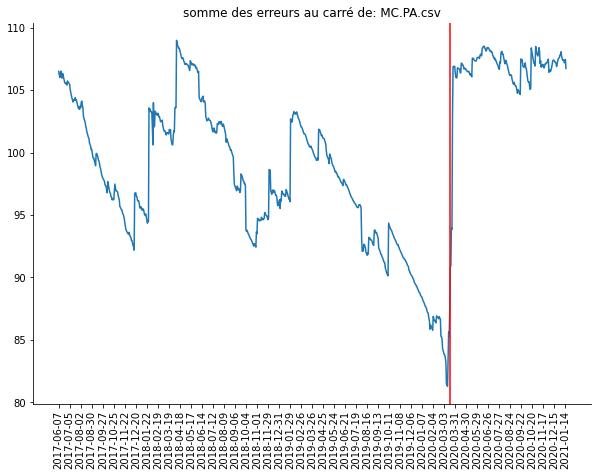

******************************
Etude de: AC.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=137.147
- les paramétres de la sedonde loi: a2=0.703 b2=41.683
- la date de rupture est le 2020-03-06


graphiques


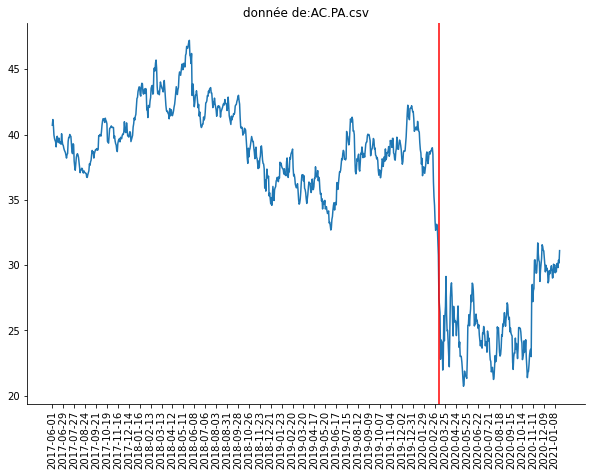

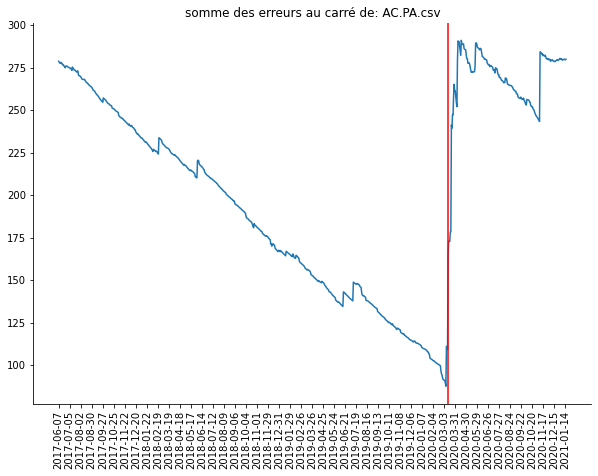

******************************
Etude de: HO.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=125.951
- les paramétres de la sedonde loi: a2=0.701 b2=55.168
- la date de rupture est le 2020-03-13


graphiques


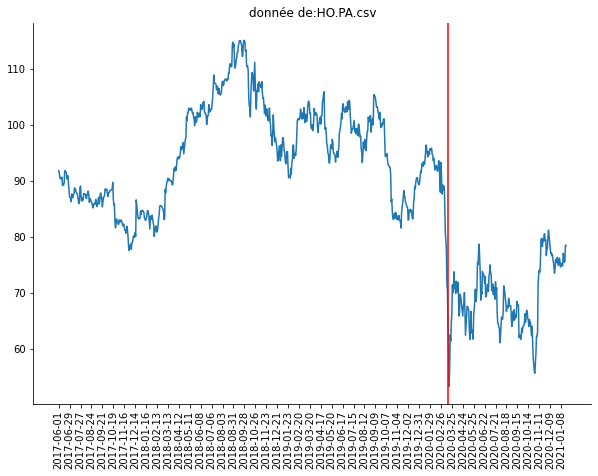

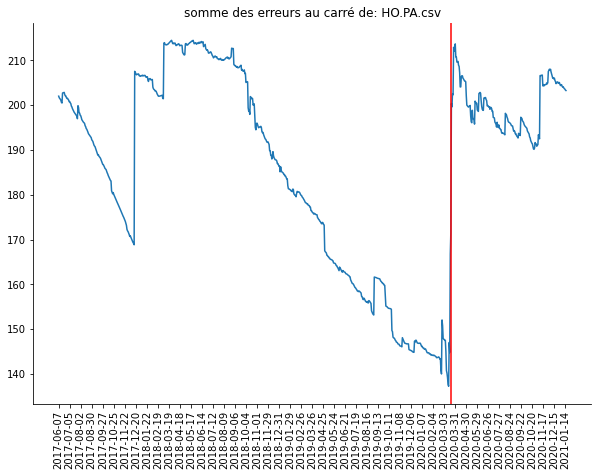

******************************
Etude de: SU.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=132.822
- les paramétres de la sedonde loi: a2=0.7 b2=65.238
- la date de rupture est le 2020-02-19


graphiques


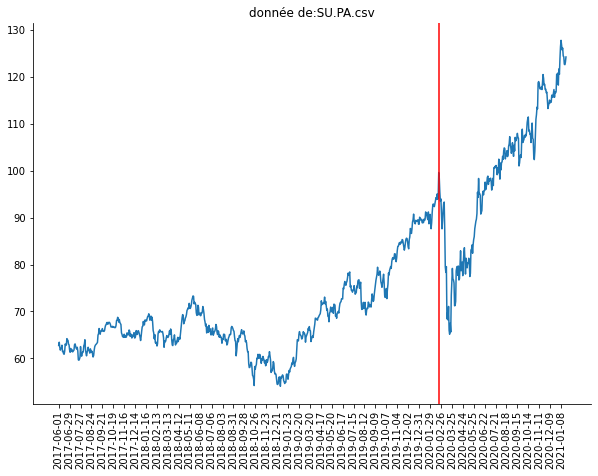

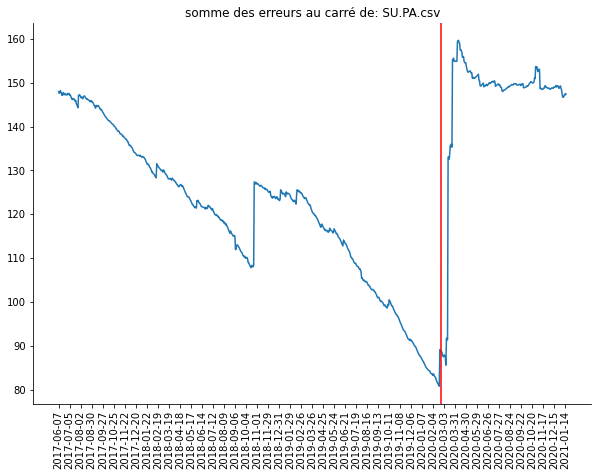

******************************
Etude de: BNP.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=127.85
- les paramétres de la sedonde loi: a2=0.703 b2=43.71
- la date de rupture est le 2020-03-06


graphiques


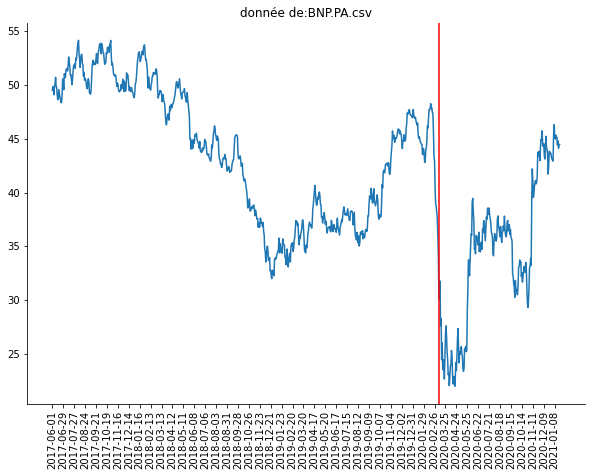

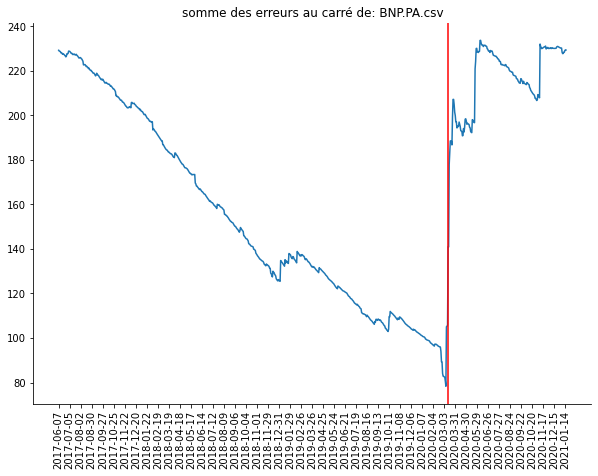

******************************
Etude de: FP.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.696 b1=156.274
- les paramétres de la sedonde loi: a2=0.702 b2=46.756
- la date de rupture est le 2020-03-06


graphiques


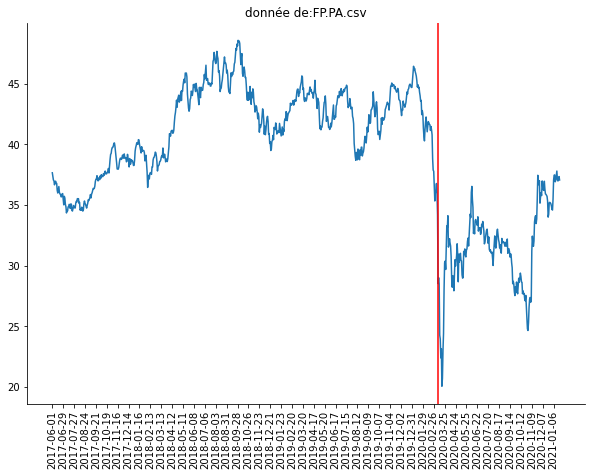

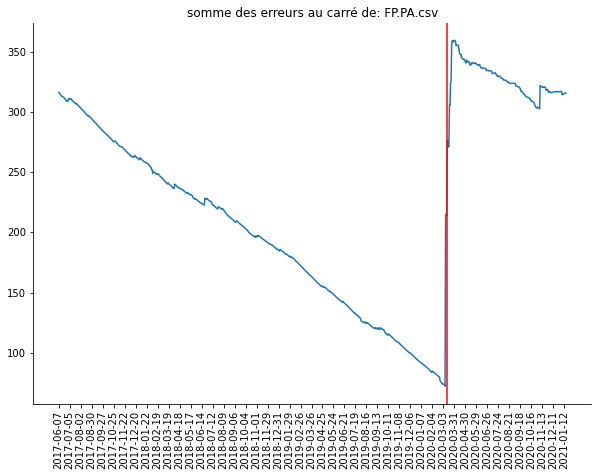

******************************
Etude de: CAP.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.697 b1=109.002
- les paramétres de la sedonde loi: a2=0.701 b2=58.025
- la date de rupture est le 2020-03-11


graphiques


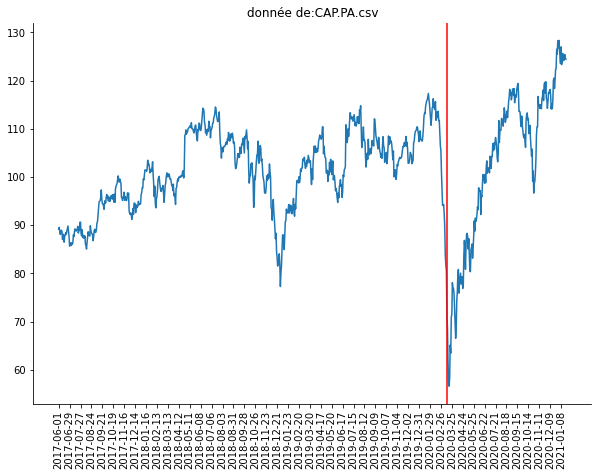

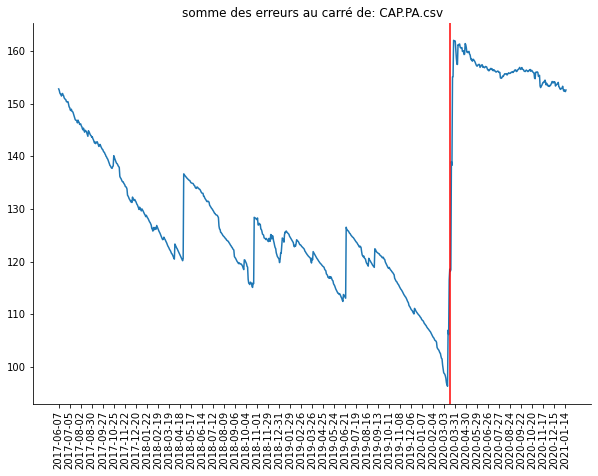

******************************
Etude de: CA.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.697 b1=93.66
- les paramétres de la sedonde loi: a2=0.709 b2=20.078
- la date de rupture est le 2021-01-12


graphiques


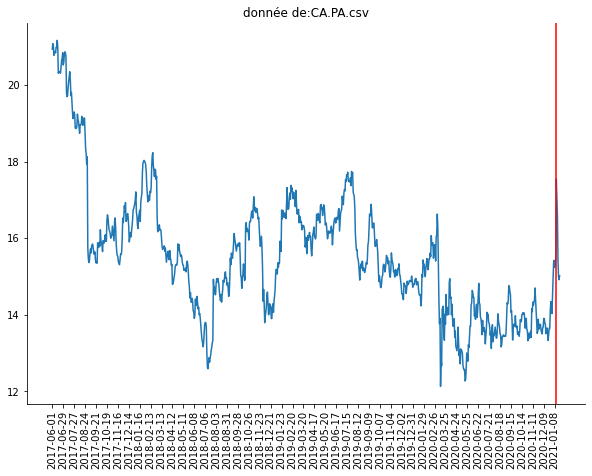

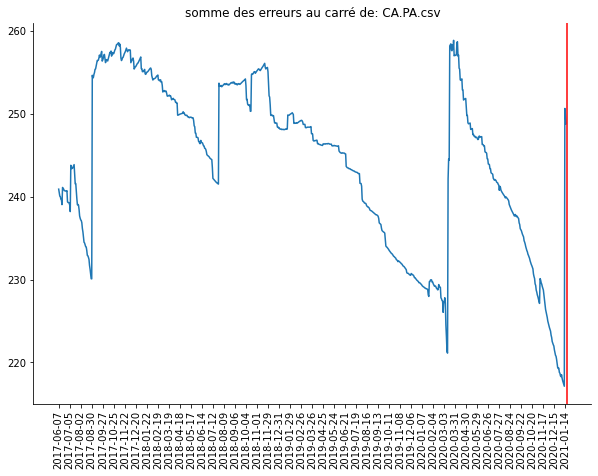

******************************
Etude de: SAN.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.695 b1=168.139
- les paramétres de la sedonde loi: a2=0.697 b2=109.7
- la date de rupture est le 2019-04-18


graphiques


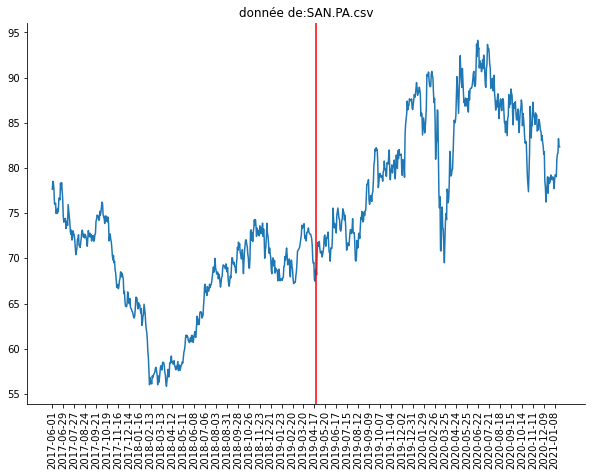

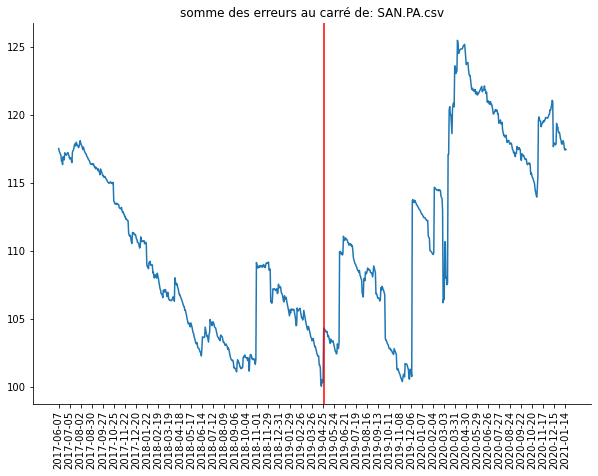

******************************
Etude de: UG.PA.csv
******************************


Les paramétres calculés:
- les paramétres de la première loi: a1=0.697 b1=125.9
- les paramétres de la sedonde loi: a2=0.7 b2=60.139
- la date de rupture est le 2018-07-23


graphiques


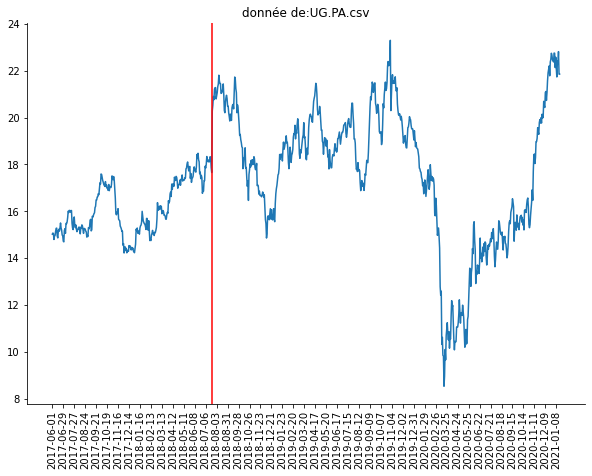

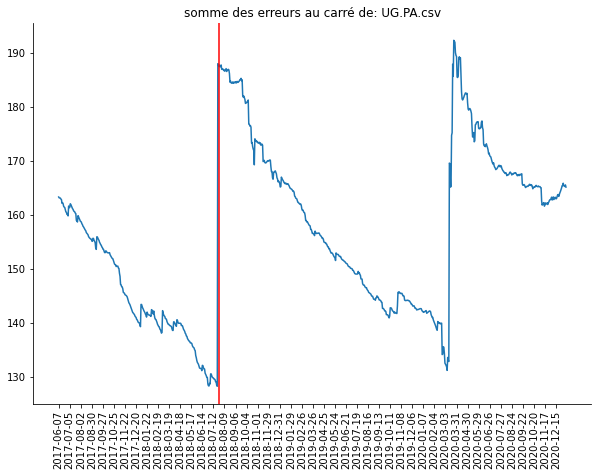

In [14]:
for i in range(len(Liste_donnees)):
    estimate_rupture(i)

## simulation de la loi de Weibull

In [15]:
#Retransforme les données suivant des lois de Weibull en des données de valeurs boursières, x0= data[0]
#args: data_transformed : les données suivant une loi de Weibull, x0: la valeur initiale pour calculer les autres valeurs
#return : liste de données similaire à des valeurs boursières
def detransform(data_transformed, x0):
    x=[x0]
    for i in range(1,len(data)):
        x.append((np.exp(data_transformed[i-1])-1)*x[i-1])

    return x

#Affiche dans un graphiques les données simulées par un modèle de Weibull vs les vrais données
#args : weibull1 : w1(a1, b1), weibull2 : w2(a2, b2), data : les vrais données boursières, name : le nom de l'entreprise
def plot_comparaison(weibull1, weibull2, k, data, name):
    n = len(data_transformed)
    w1 = weibull1[0]*np.random.weibull(weibull1[1], size=k)
    w2 = weibull2[0]*np.random.weibull(weibull2[1], size =n-k)
    w = np.concatenate([w1,w2])
    y = detransform(w, data[0])
    x = [i for i in range(n+1)]
    
    plt.clf()
    plt.title("{} Weibull W1(a={:.2f},b={:.2f}), W2(a={:.2f},b={:.2f}),k={}".format(name, weibull1[0], weibull1[1], weibull2[0], weibull2[1], k))
    plt.plot(data, label="Vrais valeurs boursières")
    plt.plot(x, y, 'r--', label="Valeurs boursières simulées")
    plt.legend()
    plt.xlabel("Temps")
    plt.show()

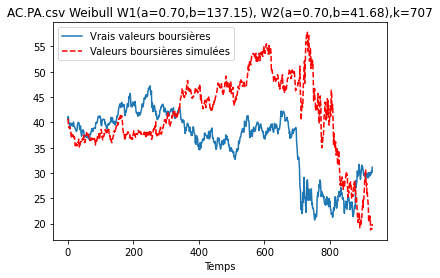

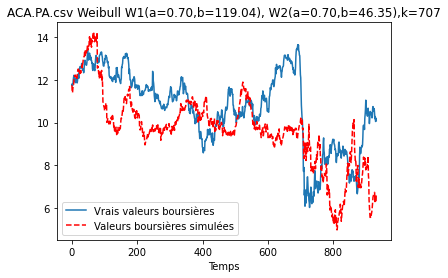

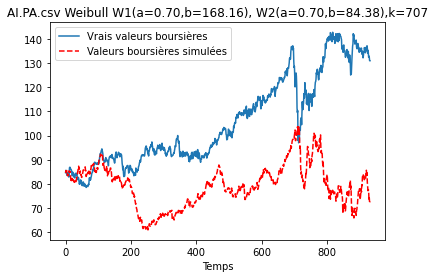

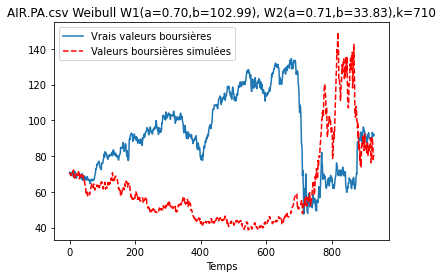

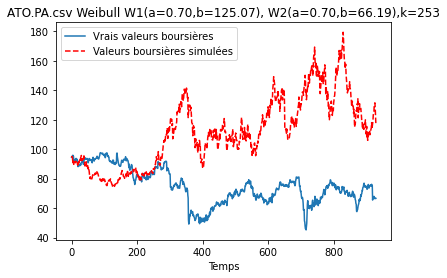

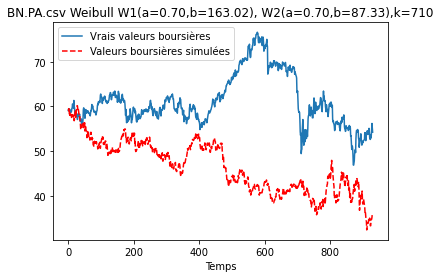

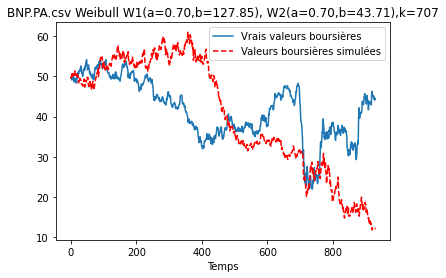

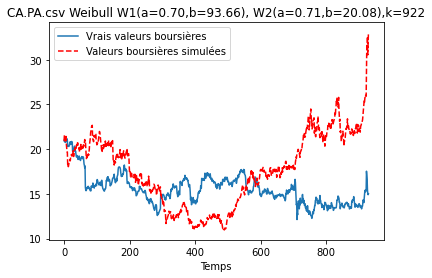

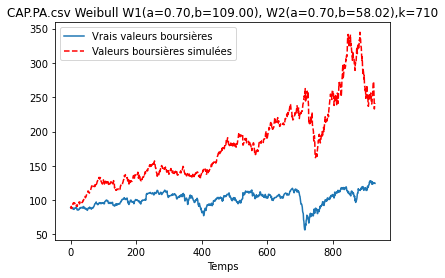

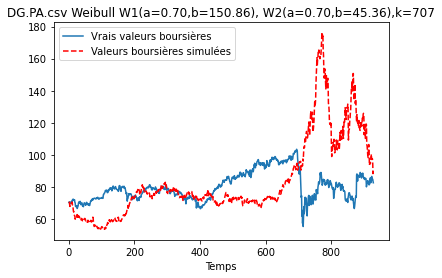

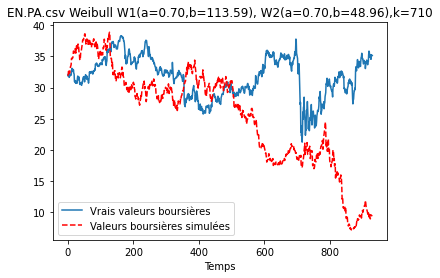

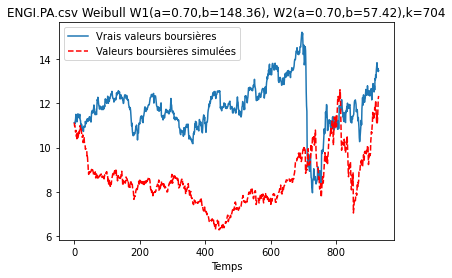

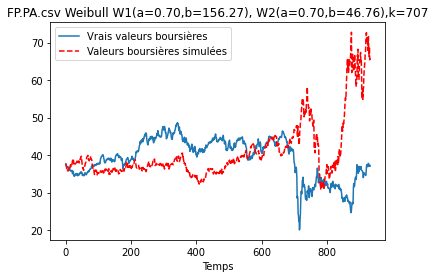

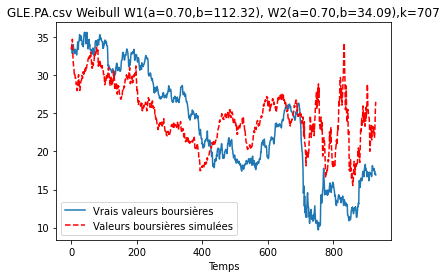

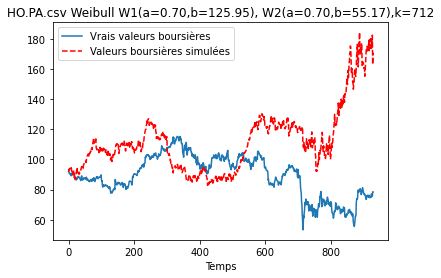

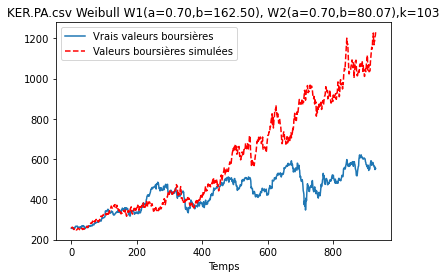

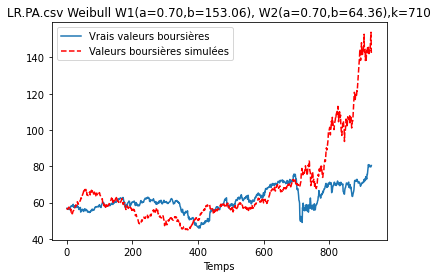

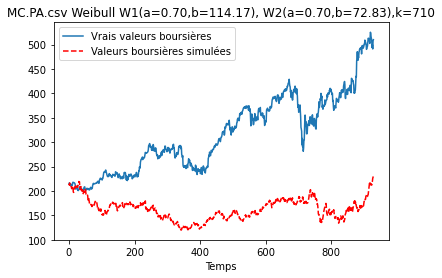

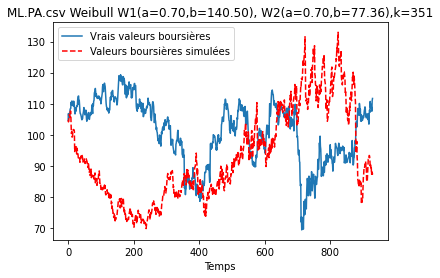

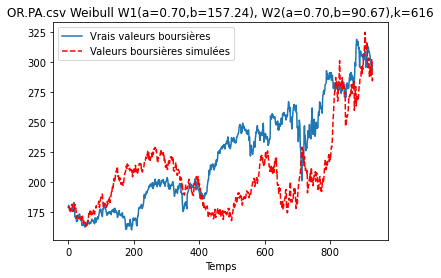

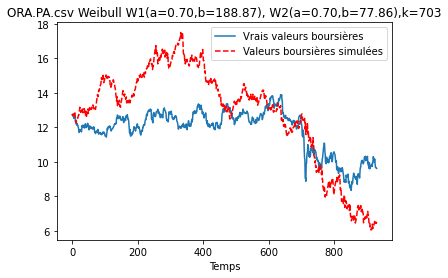

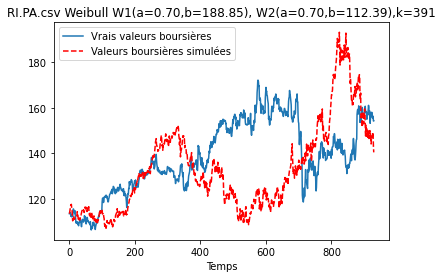

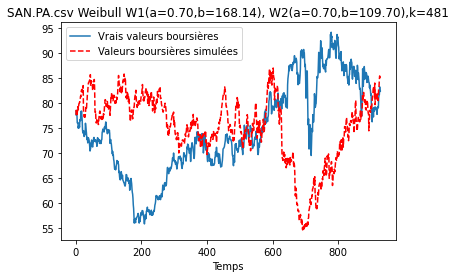

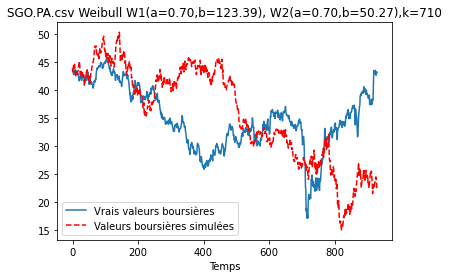

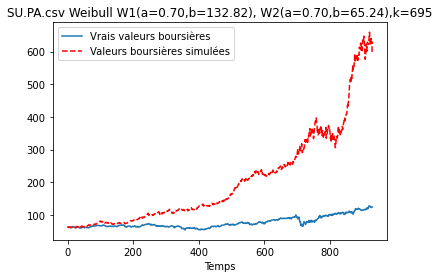

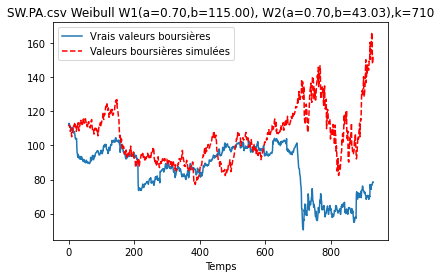

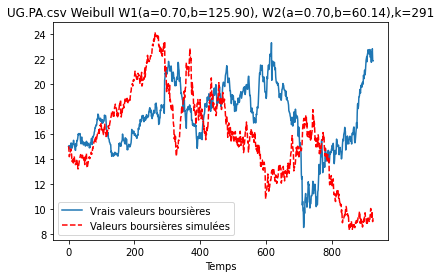

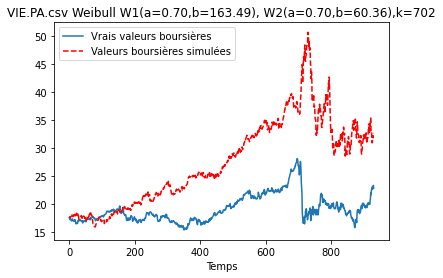

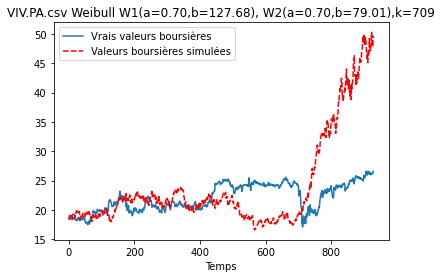

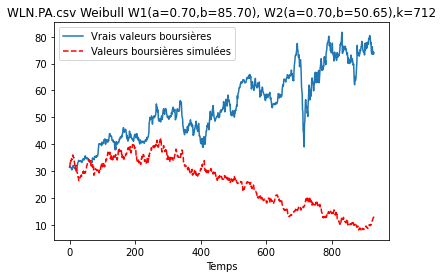

In [34]:
for i in range(len(Liste_donnees)):
    #plot des valeurs simulation et des vrais
    data = load_data(i)
    data_transformed = transform_data(data['Adj Close'])
    n=len(data_transformed.index)
    b, a, k,err = compute_best_param(data_transformed,n)
    plot_comparaison((a[0], b[0]), (a[1], b[1]), k, data['Adj Close'].values, str(Liste_donnees[i]))